Import important parameter

In [2]:
inputsize =193
e = 0.0063

Import Package

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [4]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [5]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [6]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.7911776096730994


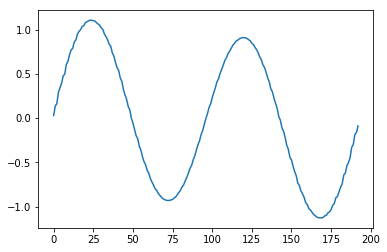

In [7]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.12611601055313804


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.9139455614469021
Iteration 200/4000
Upper bound estimation = 0.8979908607047172
Iteration 300/4000
Upper bound estimation = 0.8895417178814987
Iteration 400/4000
Upper bound estimation = 0.9050604137896492
Iteration 500/4000
Upper bound estimation = 0.8718165705656291
Iteration 600/4000
Upper bound estimation = 0.837660293102155
Iteration 700/4000
Upper bound estimation = 0.8322628535942884
Iteration 800/4000
Upper bound estimation = 0.8299766253389834
Iteration 900/4000
Upper bound estimation = 0.8437047127447683
Iteration 1000/4000
Upper bound estimation = 0.8008965662434785
Iteration 1100/4000
Upper bound estimation = 0.8026605205060217
Iteration 1200/4000
Upper bound estimation = 0.7962409210689582
Iteration 1300/4000
Upper bound estimation = 0.779518453097428
Iteration 1400/4000
Upper bound estimation = 0.7934134734466065
Iteration 1500/4000
Upper bound estimation = 0.7728021401256492
Iteration 1600/4000
Upper bound estimation = 0.7700

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.5267251932385444


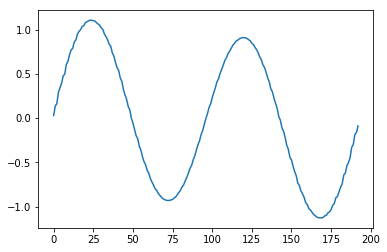

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.12611601055872299


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.12215100597271389
L = 0.03
rho = 0.12329242882923228
L = 0.04
rho = 0.12476621184190136
L = 0.05
rho = 0.1264421463652462
L = 0.060000000000000005
rho = 0.1282981451361582
L = 0.07
rho = 0.1303510882478573
L = 0.08
rho = 0.13261636452313239
L = 0.09
rho = 0.13507376667042856
L = 0.09999999999999999
rho = 0.13768045036211468
L = 0.10999999999999999
rho = 0.14039519872006773
L = 0.11999999999999998
rho = 0.14318603464386453
L = 0.12999999999999998
rho = 0.1460304369000666
L = 0.13999999999999999
rho = 0.14891330228497235
L = 0.15
rho = 0.15182460820965882
L = 0.16
rho = 0.1547575850867724
L = 0.17
rho = 0.1577074899214107
L = 0.18000000000000002
rho = 0.16067083815977795
L = 0.19000000000000003
rho = 0.1636449367477081
L = 0.20000000000000004
rho = 0.16662760293205522
L = 0.21000000000000005
rho = 0.1696169944858009
L = 0.22000000000000006
rho = 0.17261150615349397
L = 0.23000000000000007
rho = 0.17560970547907295
L = 0.24000000000000007
rho = 0.178

the 26 steps
rho = 0.3770556036193587
the 27 steps
rho = 0.37698801344100347
the 28 steps
rho = 0.3769208947094357
the 29 steps
rho = 0.3768542352437552
the 30 steps
rho = 0.3767880235771429
the 31 steps
rho = 0.37672224890403555
the 32 steps
rho = 0.37665690103091015
the 33 steps
rho = 0.3765919703304925
the 34 steps
rho = 0.37652744769920105
the 35 steps
rho = 0.3764633245176412
the 36 steps
rho = 0.37639959261397365
the 37 steps
rho = 0.37633624422998074
the 38 steps
rho = 0.3762732719896648
the 39 steps
rho = 0.37621066887022175
the 40 steps
rho = 0.3761484281752168
the 41 steps
rho = 0.3760865435098481
the 42 steps
rho = 0.3760250087581352
the 43 steps
rho = 0.3759638180618893
the 44 steps
rho = 0.37590296580137506
the 45 steps
rho = 0.375842446577506
the 46 steps
rho = 0.375782255195503
the 47 steps
rho = 0.37572238664985125
the 48 steps
rho = 0.3756628361105294
the 49 steps
rho = 0.3756035989103574
the 50 steps
rho = 0.37554467053340534
the 51 steps
rho = 0.3754860466043804
the 

the 166 steps
rho = 0.37008607182756337
the 167 steps
rho = 0.3700469235612983
the 168 steps
rho = 0.37000786750091086
the 169 steps
rho = 0.36996890297568724
the 170 steps
rho = 0.36993002932384356
the 171 steps
rho = 0.3698912458923757
the 172 steps
rho = 0.36985255203689277
the 173 steps
rho = 0.36981394712147003
the 174 steps
rho = 0.36977543051848816
the 175 steps
rho = 0.3697370016084934
the 176 steps
rho = 0.36969865978004274
the 177 steps
rho = 0.36966040442956627
the 178 steps
rho = 0.36962223496122276
the 179 steps
rho = 0.36958415078676005
the 180 steps
rho = 0.36954615132538166
the 181 steps
rho = 0.3695082360036124
the 182 steps
rho = 0.3694704042551653
the 183 steps
rho = 0.3694326555208131
the 184 steps
rho = 0.3693949892482646
the 185 steps
rho = 0.36935740489203955
the 186 steps
rho = 0.36931990191334785
the 187 steps
rho = 0.36928247977996737
the 188 steps
rho = 0.36924513796613034
the 189 steps
rho = 0.3692078759524082
the 190 steps
rho = 0.36917069322559737
the 191 

the 306 steps
rho = 0.365293118561759
the 307 steps
rho = 0.36526277434332194
the 308 steps
rho = 0.36523247394011604
the 309 steps
rho = 0.3652022171753663
the 310 steps
rho = 0.36517200387356324
the 311 steps
rho = 0.365141833860455
the 312 steps
rho = 0.3651117069630313
the 313 steps
rho = 0.36508162300951846
the 314 steps
rho = 0.3650515818293652
the 315 steps
rho = 0.36502158325322986
the 316 steps
rho = 0.3649916271129748
the 317 steps
rho = 0.36496171324165333
the 318 steps
rho = 0.36493184147349805
the 319 steps
rho = 0.3649020116439133
the 320 steps
rho = 0.3648722235894625
the 321 steps
rho = 0.3648424771478604
the 322 steps
rho = 0.3648127721579638
the 323 steps
rho = 0.3647831084597566
the 324 steps
rho = 0.36475348589434553
the 325 steps
rho = 0.364723904303951
the 326 steps
rho = 0.36469436353189244
the 327 steps
rho = 0.3646648634225843
the 328 steps
rho = 0.3646354038215246
the 329 steps
rho = 0.3646059845752841
the 330 steps
rho = 0.3645766055315001
the 331 steps
rho =

the 446 steps
rho = 0.3614078189019305
the 447 steps
rho = 0.36138232413376625
the 448 steps
rho = 0.3613568571348724
the 449 steps
rho = 0.36133141783422107
the 450 steps
rho = 0.36130600616119624
the 451 steps
rho = 0.36128062204559436
the 452 steps
rho = 0.3612552654176174
the 453 steps
rho = 0.36122993620787247
the 454 steps
rho = 0.3612046343473681
the 455 steps
rho = 0.3611793597675108
the 456 steps
rho = 0.3611541124001059
the 457 steps
rho = 0.36112889217734473
the 458 steps
rho = 0.36110369903181544
the 459 steps
rho = 0.3610785328964879
the 460 steps
rho = 0.3610533937047195
the 461 steps
rho = 0.36102828139024545
the 462 steps
rho = 0.3610031958871834
the 463 steps
rho = 0.36097813713002175
the 464 steps
rho = 0.36095310505362477
the 465 steps
rho = 0.36092809959322675
the 466 steps
rho = 0.36090312068442804
the 467 steps
rho = 0.36087816826319674
the 468 steps
rho = 0.36085324226585797
the 469 steps
rho = 0.36082834262909996
the 470 steps
rho = 0.36080346928996687
the 471 s

the 590 steps
rho = 0.3579937492188709
the 591 steps
rho = 0.35797168134395313
the 592 steps
rho = 0.3579496341383009
the 593 steps
rho = 0.3579276075686626
the 594 steps
rho = 0.35790560160194784
the 595 steps
rho = 0.35788361620522696
the 596 steps
rho = 0.3578616513457269
the 597 steps
rho = 0.3578397069908326
the 598 steps
rho = 0.3578177831080857
the 599 steps
rho = 0.35779587966518406
the 600 steps
rho = 0.35777399662997733
the 601 steps
rho = 0.3577521339704734
the 602 steps
rho = 0.35773029165482995
the 603 steps
rho = 0.3577084696513586
the 604 steps
rho = 0.3576866679285201
the 605 steps
rho = 0.3576648864549276
the 606 steps
rho = 0.3576431251993428
the 607 steps
rho = 0.3576213841306741
the 608 steps
rho = 0.3575996632179839
the 609 steps
rho = 0.3575779624304728
the 610 steps
rho = 0.3575562817374934
the 611 steps
rho = 0.3575346211085429
the 612 steps
rho = 0.3575129805132605
the 613 steps
rho = 0.3574913599214318
the 614 steps
rho = 0.35746975930298197
the 615 steps
rho 

the 733 steps
rho = 0.3550343292332984
the 734 steps
rho = 0.355014942655121
the 735 steps
rho = 0.35499557325215275
the 736 steps
rho = 0.354976221006708
the 737 steps
rho = 0.3549568859011648
the 738 steps
rho = 0.3549375679179704
the 739 steps
rho = 0.3549182670396378
the 740 steps
rho = 0.35489898324874714
the 741 steps
rho = 0.3548797165279441
the 742 steps
rho = 0.3548604668599407
the 743 steps
rho = 0.354841234227514
the 744 steps
rho = 0.3548220186135061
the 745 steps
rho = 0.35480282000082286
the 746 steps
rho = 0.3547836383724329
the 747 steps
rho = 0.35476447371137365
the 748 steps
rho = 0.35474532600073816
the 749 steps
rho = 0.35472619522369114
the 750 steps
rho = 0.35470708136345075
the 751 steps
rho = 0.3546879844032992
the 752 steps
rho = 0.3546689043265845
the 753 steps
rho = 0.35464984111671227
the 754 steps
rho = 0.3546307947571484
the 755 steps
rho = 0.3546117652314237
the 756 steps
rho = 0.3545927525231214
the 757 steps
rho = 0.3545737566158892
the 758 steps
rho = 

the 872 steps
rho = 0.35249742822563934
the 873 steps
rho = 0.3524802834004914
the 874 steps
rho = 0.35246315378233634
the 875 steps
rho = 0.35244603935963525
the 876 steps
rho = 0.35242894012087117
the 877 steps
rho = 0.35241185605455383
the 878 steps
rho = 0.35239478714922506
the 879 steps
rho = 0.3523777333934431
the 880 steps
rho = 0.35236069477579957
the 881 steps
rho = 0.35234367128490585
the 882 steps
rho = 0.3523266629094018
the 883 steps
rho = 0.3523096696379548
the 884 steps
rho = 0.35229269145924946
the 885 steps
rho = 0.3522757283620005
the 886 steps
rho = 0.35225878033494656
the 887 steps
rho = 0.35224184736685177
the 888 steps
rho = 0.3522249294465008
the 889 steps
rho = 0.3522080265627058
the 890 steps
rho = 0.35219113870429847
the 891 steps
rho = 0.35217426586014167
the 892 steps
rho = 0.3521574080191116
the 893 steps
rho = 0.35214056517011605
the 894 steps
rho = 0.3521237373020842
the 895 steps
rho = 0.35210692440396435
the 896 steps
rho = 0.3520901264647315
the 897 st

the 1011 steps
rho = 0.35025541706516916
the 1012 steps
rho = 0.35024028438112254
the 1013 steps
rho = 0.3502251654814594
the 1014 steps
rho = 0.35021006035680285
the 1015 steps
rho = 0.3501949689977845
the 1016 steps
rho = 0.35017989139503997
the 1017 steps
rho = 0.3501648275392141
the 1018 steps
rho = 0.3501497774209519
the 1019 steps
rho = 0.35013474103091047
the 1020 steps
rho = 0.3501197183597494
the 1021 steps
rho = 0.35010470939813154
the 1022 steps
rho = 0.3500897141367308
the 1023 steps
rho = 0.350074732566219
the 1024 steps
rho = 0.3500597646772815
the 1025 steps
rho = 0.3500448104606015
the 1026 steps
rho = 0.350029869906873
the 1027 steps
rho = 0.3500149430067881
the 1028 steps
rho = 0.35000002975105
the 1029 steps
rho = 0.34998513013036237
the 1030 steps
rho = 0.3499702441354356
the 1031 steps
rho = 0.34995537175698516
the 1032 steps
rho = 0.34994051298572454
the 1033 steps
rho = 0.3499256678123811
the 1034 steps
rho = 0.34991083622768
the 1035 steps
rho = 0.34989601822234

the 1147 steps
rho = 0.3483201146854775
the 1148 steps
rho = 0.34830677174385594
the 1149 steps
rho = 0.34829344132780116
the 1150 steps
rho = 0.34828012342793263
the 1151 steps
rho = 0.3482668180348693
the 1152 steps
rho = 0.3482535251392228
the 1153 steps
rho = 0.3482402447316001
the 1154 steps
rho = 0.34822697680261105
the 1155 steps
rho = 0.34821372134284856
the 1156 steps
rho = 0.348200478342914
the 1157 steps
rho = 0.3481872477933984
the 1158 steps
rho = 0.348174029684883
the 1159 steps
rho = 0.3481608240079542
the 1160 steps
rho = 0.34814763075318705
the 1161 steps
rho = 0.3481344499111548
the 1162 steps
rho = 0.348121281472426
the 1163 steps
rho = 0.3481081254275618
the 1164 steps
rho = 0.34809498176712367
the 1165 steps
rho = 0.348081850481663
the 1166 steps
rho = 0.34806873156172663
the 1167 steps
rho = 0.34805562499786563
the 1168 steps
rho = 0.3480425307806106
the 1169 steps
rho = 0.34802944890050486
the 1170 steps
rho = 0.34801637934807134
the 1171 steps
rho = 0.3480033221

the 1287 steps
rho = 0.3465697047935701
the 1288 steps
rho = 0.3465580219912826
the 1289 steps
rho = 0.3465463503538055
the 1290 steps
rho = 0.34653468987108704
the 1291 steps
rho = 0.34652304053307265
the 1292 steps
rho = 0.34651140232970473
the 1293 steps
rho = 0.3464997752509183
the 1294 steps
rho = 0.3464881592866506
the 1295 steps
rho = 0.3464765544268275
the 1296 steps
rho = 0.3464649606613783
the 1297 steps
rho = 0.3464533779802239
the 1298 steps
rho = 0.34644180637328625
the 1299 steps
rho = 0.3464302458304765
the 1300 steps
rho = 0.3464186963417084
the 1301 steps
rho = 0.34640715789689225
the 1302 steps
rho = 0.34639563048592953
the 1303 steps
rho = 0.34638411409872544
the 1304 steps
rho = 0.3463726087251738
the 1305 steps
rho = 0.3463611143551699
the 1306 steps
rho = 0.3463496309786063
the 1307 steps
rho = 0.34633815858536915
the 1308 steps
rho = 0.3463266971653424
the 1309 steps
rho = 0.34631524670840824
the 1310 steps
rho = 0.34630380720444337
the 1311 steps
rho = 0.3462923

the 1429 steps
rho = 0.34501777391184074
the 1430 steps
rho = 0.3450075746163651
the 1431 steps
rho = 0.3449973850352051
the 1432 steps
rho = 0.3449872051580936
the 1433 steps
rho = 0.3449770349747785
the 1434 steps
rho = 0.3449668744749858
the 1435 steps
rho = 0.3449567236484692
the 1436 steps
rho = 0.344946582484961
the 1437 steps
rho = 0.34493645097420456
the 1438 steps
rho = 0.3449263291059423
the 1439 steps
rho = 0.34491621686992585
the 1440 steps
rho = 0.3449061142558929
the 1441 steps
rho = 0.34489602125359786
the 1442 steps
rho = 0.3448859378527844
the 1443 steps
rho = 0.344875864043204
the 1444 steps
rho = 0.3448657998146087
the 1445 steps
rho = 0.34485574515675177
the 1446 steps
rho = 0.34484570005938703
the 1447 steps
rho = 0.3448356645122709
the 1448 steps
rho = 0.3448256385051581
the 1449 steps
rho = 0.3448156220278127
the 1450 steps
rho = 0.3448056150699934
the 1451 steps
rho = 0.34479561762145683
the 1452 steps
rho = 0.34478562967197474
the 1453 steps
rho = 0.34477565121

the 1568 steps
rho = 0.3436887756392917
the 1569 steps
rho = 0.34367982915136425
the 1570 steps
rho = 0.3436708909756035
the 1571 steps
rho = 0.34366196110219716
the 1572 steps
rho = 0.34365303952135184
the 1573 steps
rho = 0.34364412622326046
the 1574 steps
rho = 0.34363522119813694
the 1575 steps
rho = 0.3436263244361889
the 1576 steps
rho = 0.34361743592764615
the 1577 steps
rho = 0.3436085556627227
the 1578 steps
rho = 0.34359968363165294
the 1579 steps
rho = 0.3435908198246674
the 1580 steps
rho = 0.3435819642320121
the 1581 steps
rho = 0.34357311684393294
the 1582 steps
rho = 0.3435642776506807
the 1583 steps
rho = 0.34355544664251336
the 1584 steps
rho = 0.3435466238096928
the 1585 steps
rho = 0.34353780914248755
the 1586 steps
rho = 0.3435290026311773
the 1587 steps
rho = 0.3435202042660354
the 1588 steps
rho = 0.34351141403735197
the 1589 steps
rho = 0.3435026319354172
the 1590 steps
rho = 0.3434938579505305
the 1591 steps
rho = 0.34348509207299305
the 1592 steps
rho = 0.34347

the 1710 steps
rho = 0.34249710248084064
the 1711 steps
rho = 0.342489240999609
the 1712 steps
rho = 0.34248138650169235
the 1713 steps
rho = 0.3424735389782508
the 1714 steps
rho = 0.34246569842046065
the 1715 steps
rho = 0.3424578648194989
the 1716 steps
rho = 0.34245003816655195
the 1717 steps
rho = 0.34244221845281864
the 1718 steps
rho = 0.34243440566949634
the 1719 steps
rho = 0.3424265998078016
the 1720 steps
rho = 0.34241880085894916
the 1721 steps
rho = 0.34241100881417
the 1722 steps
rho = 0.3424032236646962
the 1723 steps
rho = 0.34239544540177624
the 1724 steps
rho = 0.34238767401666104
the 1725 steps
rho = 0.3423799095006111
the 1726 steps
rho = 0.34237215184489284
the 1727 steps
rho = 0.34236440104078003
the 1728 steps
rho = 0.3423566570795662
the 1729 steps
rho = 0.3423489199525361
the 1730 steps
rho = 0.34234118965099136
the 1731 steps
rho = 0.34233346616624694
the 1732 steps
rho = 0.3423257494896175
the 1733 steps
rho = 0.34231803961242746
the 1734 steps
rho = 0.342310

the 1851 steps
rho = 0.3414536489477782
the 1852 steps
rho = 0.3414466887244264
the 1853 steps
rho = 0.34143973432196184
the 1854 steps
rho = 0.3414327857327627
the 1855 steps
rho = 0.3414258429492166
the 1856 steps
rho = 0.3414189059637263
the 1857 steps
rho = 0.34141197476868845
the 1858 steps
rho = 0.34140504935651894
the 1859 steps
rho = 0.3413981297196416
the 1860 steps
rho = 0.34139121585049625
the 1861 steps
rho = 0.3413843077415169
the 1862 steps
rho = 0.34137740538515665
the 1863 steps
rho = 0.34137050877387465
the 1864 steps
rho = 0.34136361790013886
the 1865 steps
rho = 0.34135673275642975
the 1866 steps
rho = 0.3413498533352314
the 1867 steps
rho = 0.3413429796290358
the 1868 steps
rho = 0.34133611163035144
the 1869 steps
rho = 0.34132924933169373
the 1870 steps
rho = 0.3413223927255825
the 1871 steps
rho = 0.3413155418045482
the 1872 steps
rho = 0.3413086965611311
the 1873 steps
rho = 0.3413018569878803
the 1874 steps
rho = 0.34129502307735354
the 1875 steps
rho = 0.341288

the 1993 steps
rho = 0.34052015519219336
the 1994 steps
rho = 0.34051394942343693
the 1995 steps
rho = 0.3405077484828482
the 1996 steps
rho = 0.34050155236406376
the 1997 steps
rho = 0.3404953610607344
the 1998 steps
rho = 0.34048917456652145
the 1999 steps
rho = 0.34048299287508393
the 2000 steps
rho = 0.34047681598010965
the 2001 steps
rho = 0.3404706438752758
the 2002 steps
rho = 0.34046447655427414
the 2003 steps
rho = 0.34045831401080784
the 2004 steps
rho = 0.34045215623858616
the 2005 steps
rho = 0.3404460032313307
the 2006 steps
rho = 0.3404398549827618
the 2007 steps
rho = 0.34043371148662477
the 2008 steps
rho = 0.3404275727366587
the 2009 steps
rho = 0.3404214387266152
the 2010 steps
rho = 0.34041530945025805
the 2011 steps
rho = 0.3404091849013621
the 2012 steps
rho = 0.3404030650736981
the 2013 steps
rho = 0.34039694996106057
the 2014 steps
rho = 0.3403908395572394
the 2015 steps
rho = 0.340384733856042
the 2016 steps
rho = 0.34037863285128744
the 2017 steps
rho = 0.34037

the 2133 steps
rho = 0.3396956099051554
the 2134 steps
rho = 0.33969002199609427
the 2135 steps
rho = 0.3396844381065962
the 2136 steps
rho = 0.3396788582314612
the 2137 steps
rho = 0.33967328236548683
the 2138 steps
rho = 0.3396677105034831
the 2139 steps
rho = 0.33966214264026595
the 2140 steps
rho = 0.3396565787706661
the 2141 steps
rho = 0.33965101888950905
the 2142 steps
rho = 0.33964546299164144
the 2143 steps
rho = 0.3396399110719078
the 2144 steps
rho = 0.339634363125163
the 2145 steps
rho = 0.33962881914627485
the 2146 steps
rho = 0.3396232791301097
the 2147 steps
rho = 0.33961774307155046
the 2148 steps
rho = 0.339612210965478
the 2149 steps
rho = 0.339606682806796
the 2150 steps
rho = 0.33960115859039675
the 2151 steps
rho = 0.3395956383111899
the 2152 steps
rho = 0.3395901219640992
the 2153 steps
rho = 0.3395846095440458
the 2154 steps
rho = 0.33957910104595646
the 2155 steps
rho = 0.3395735964647791
the 2156 steps
rho = 0.3395680957954575
the 2157 steps
rho = 0.33956259903

the 2273 steps
rho = 0.33895019815805455
the 2274 steps
rho = 0.33894512567211066
the 2275 steps
rho = 0.3389400565485029
the 2276 steps
rho = 0.3389349907830201
the 2277 steps
rho = 0.3389299283714665
the 2278 steps
rho = 0.3389248693096574
the 2279 steps
rho = 0.3389198135933993
the 2280 steps
rho = 0.3389147612185216
the 2281 steps
rho = 0.33890971218085336
the 2282 steps
rho = 0.3389046664762293
the 2283 steps
rho = 0.33889962410048596
the 2284 steps
rho = 0.3388945850494813
the 2285 steps
rho = 0.33888954931906407
the 2286 steps
rho = 0.3388845169050952
the 2287 steps
rho = 0.33887948780344723
the 2288 steps
rho = 0.33887446200999166
the 2289 steps
rho = 0.33886943952060833
the 2290 steps
rho = 0.33886442033118686
the 2291 steps
rho = 0.3388594044376186
the 2292 steps
rho = 0.3388543918358061
the 2293 steps
rho = 0.33884938252165725
the 2294 steps
rho = 0.3388443764910823
the 2295 steps
rho = 0.3388393737399989
the 2296 steps
rho = 0.3388343742643369
the 2297 steps
rho = 0.3388293

the 2411 steps
rho = 0.3382802692341789
the 2412 steps
rho = 0.3382756236961843
the 2413 steps
rho = 0.338270980998661
the 2414 steps
rho = 0.3382663411382309
the 2415 steps
rho = 0.3382617041115211
the 2416 steps
rho = 0.3382570699151522
the 2417 steps
rho = 0.33825243854576387
the 2418 steps
rho = 0.33824781000000376
the 2419 steps
rho = 0.33824318427451006
the 2420 steps
rho = 0.3382385613659327
the 2421 steps
rho = 0.3382339412709331
the 2422 steps
rho = 0.33822932398617467
the 2423 steps
rho = 0.33822470950832223
the 2424 steps
rho = 0.33822009783404144
the 2425 steps
rho = 0.3382154889600194
the 2426 steps
rho = 0.3382108828829389
the 2427 steps
rho = 0.3382062795994827
the 2428 steps
rho = 0.3382016791063478
the 2429 steps
rho = 0.338197081400232
the 2430 steps
rho = 0.3381924864778375
the 2431 steps
rho = 0.3381878943358794
the 2432 steps
rho = 0.3381833049710704
the 2433 steps
rho = 0.33817871838012664
the 2434 steps
rho = 0.33817413455977763
the 2435 steps
rho = 0.33816955350

the 2548 steps
rho = 0.337668947455962
the 2549 steps
rho = 0.33766466170478654
the 2550 steps
rho = 0.33766037837757135
the 2551 steps
rho = 0.33765609747159286
the 2552 steps
rho = 0.33765181898414204
the 2553 steps
rho = 0.3376475429124963
the 2554 steps
rho = 0.33764326925396093
the 2555 steps
rho = 0.3376389980058261
the 2556 steps
rho = 0.3376347291654038
the 2557 steps
rho = 0.33763046272998465
the 2558 steps
rho = 0.33762619869689087
the 2559 steps
rho = 0.33762193706343435
the 2560 steps
rho = 0.33761767782693874
the 2561 steps
rho = 0.3376134209847188
the 2562 steps
rho = 0.3376091665341015
the 2563 steps
rho = 0.337604914472434
the 2564 steps
rho = 0.3376006647970379
the 2565 steps
rho = 0.33759641750525543
the 2566 steps
rho = 0.33759217259443286
the 2567 steps
rho = 0.33758793006192167
the 2568 steps
rho = 0.337583689905069
the 2569 steps
rho = 0.3375794521212365
the 2570 steps
rho = 0.33757521670778495
the 2571 steps
rho = 0.3375709836620722
the 2572 steps
rho = 0.3375667

the 2687 steps
rho = 0.33709534638469807
the 2688 steps
rho = 0.33709137326158384
the 2689 steps
rho = 0.3370874022226417
the 2690 steps
rho = 0.3370834332656769
the 2691 steps
rho = 0.33707946638852143
the 2692 steps
rho = 0.3370755015889739
the 2693 steps
rho = 0.3370715388648747
the 2694 steps
rho = 0.3370675782140418
the 2695 steps
rho = 0.33706361963430254
the 2696 steps
rho = 0.33705966312349767
the 2697 steps
rho = 0.337055708679457
the 2698 steps
rho = 0.3370517563000224
the 2699 steps
rho = 0.3370478059830358
the 2700 steps
rho = 0.33704385772634127
the 2701 steps
rho = 0.3370399115277962
the 2702 steps
rho = 0.3370359673852451
the 2703 steps
rho = 0.33703202529655457
the 2704 steps
rho = 0.3370280852595666
the 2705 steps
rho = 0.33702414727215635
the 2706 steps
rho = 0.33702021133218873
the 2707 steps
rho = 0.33701627743753415
the 2708 steps
rho = 0.337012345586064
the 2709 steps
rho = 0.33700841577564694
the 2710 steps
rho = 0.3370044880041737
the 2711 steps
rho = 0.33700056

the 2824 steps
rho = 0.33656957294343565
the 2825 steps
rho = 0.33656586630936997
the 2826 steps
rho = 0.33656216148888757
the 2827 steps
rho = 0.3365584584801992
the 2828 steps
rho = 0.3365547572815357
the 2829 steps
rho = 0.336551057891124
the 2830 steps
rho = 0.33654736030719123
the 2831 steps
rho = 0.3365436645279776
the 2832 steps
rho = 0.33653997055171514
the 2833 steps
rho = 0.33653627837664524
the 2834 steps
rho = 0.33653258800100355
the 2835 steps
rho = 0.33652889942304254
the 2836 steps
rho = 0.33652521264100327
the 2837 steps
rho = 0.3365215276531385
the 2838 steps
rho = 0.336517844457696
the 2839 steps
rho = 0.33651416305292997
the 2840 steps
rho = 0.3365104834371003
the 2841 steps
rho = 0.3365068056084661
the 2842 steps
rho = 0.33650312956528783
the 2843 steps
rho = 0.33649945530583303
the 2844 steps
rho = 0.336495782828366
the 2845 steps
rho = 0.3364921121311572
the 2846 steps
rho = 0.3364884432124773
the 2847 steps
rho = 0.3364847760706089
the 2848 steps
rho = 0.33648111

the 2962 steps
rho = 0.3360744760004179
the 2963 steps
rho = 0.3360710039051435
the 2964 steps
rho = 0.33606753340119366
the 2965 steps
rho = 0.3360640644871189
the 2966 steps
rho = 0.33606059716145475
the 2967 steps
rho = 0.3360571314227552
the 2968 steps
rho = 0.3360536672695748
the 2969 steps
rho = 0.3360502047004613
the 2970 steps
rho = 0.3360467437139678
the 2971 steps
rho = 0.33604328430865527
the 2972 steps
rho = 0.3360398264830871
the 2973 steps
rho = 0.33603637023581856
the 2974 steps
rho = 0.33603291556540776
the 2975 steps
rho = 0.33602946247043314
the 2976 steps
rho = 0.3360260109494453
the 2977 steps
rho = 0.3360225610010276
the 2978 steps
rho = 0.33601911262374357
the 2979 steps
rho = 0.33601566581616754
the 2980 steps
rho = 0.33601222057687613
the 2981 steps
rho = 0.33600877690444403
the 2982 steps
rho = 0.33600533479744754
the 2983 steps
rho = 0.3360018942544765
the 2984 steps
rho = 0.3359984552741056
the 2985 steps
rho = 0.33599501785492375
the 2986 steps
rho = 0.33599

the 3103 steps
rho = 0.335599982148863
the 3104 steps
rho = 0.33559672094612053
the 3105 steps
rho = 0.3355934611480939
the 3106 steps
rho = 0.33559020275357904
the 3107 steps
rho = 0.33558694576138287
the 3108 steps
rho = 0.3355836901703009
the 3109 steps
rho = 0.33558043597914294
the 3110 steps
rho = 0.33557718318671625
the 3111 steps
rho = 0.33557393179182254
the 3112 steps
rho = 0.33557068179326893
the 3113 steps
rho = 0.33556743318987
the 3114 steps
rho = 0.33556418598043836
the 3115 steps
rho = 0.33556094016378946
the 3116 steps
rho = 0.33555769573873123
the 3117 steps
rho = 0.3355544527040769
the 3118 steps
rho = 0.3355512110586616
the 3119 steps
rho = 0.3355479708012883
the 3120 steps
rho = 0.33554473193078155
the 3121 steps
rho = 0.33554149444597325
the 3122 steps
rho = 0.33553825834567824
the 3123 steps
rho = 0.3355350236287276
the 3124 steps
rho = 0.33553179029394586
the 3125 steps
rho = 0.33552855834015777
the 3126 steps
rho = 0.335525327766204
the 3127 steps
rho = 0.335522

the 3241 steps
rho = 0.33516272220832893
the 3242 steps
rho = 0.33515964414452276
the 3243 steps
rho = 0.3351565673335422
the 3244 steps
rho = 0.33515349177438014
the 3245 steps
rho = 0.3351504174660214
the 3246 steps
rho = 0.33514734440747246
the 3247 steps
rho = 0.3351442725977222
the 3248 steps
rho = 0.3351412020357766
the 3249 steps
rho = 0.33513813272062637
the 3250 steps
rho = 0.33513506465127313
the 3251 steps
rho = 0.3351319978267231
the 3252 steps
rho = 0.33512893224597656
the 3253 steps
rho = 0.33512586790803756
the 3254 steps
rho = 0.33512280481191015
the 3255 steps
rho = 0.33511974295659896
the 3256 steps
rho = 0.3351166823411116
the 3257 steps
rho = 0.3351136229644631
the 3258 steps
rho = 0.33511056482566276
the 3259 steps
rho = 0.3351075079237113
the 3260 steps
rho = 0.335104452257631
the 3261 steps
rho = 0.3351013978264379
the 3262 steps
rho = 0.3350983446291354
the 3263 steps
rho = 0.33509529266474636
the 3264 steps
rho = 0.3350922419322879
the 3265 steps
rho = 0.335089

the 3380 steps
rho = 0.3347464636397407
the 3381 steps
rho = 0.334743550570158
the 3382 steps
rho = 0.33474063862438475
the 3383 steps
rho = 0.33473772780156624
the 3384 steps
rho = 0.33473481810084965
the 3385 steps
rho = 0.33473190952137766
the 3386 steps
rho = 0.3347290020623076
the 3387 steps
rho = 0.3347260957227894
the 3388 steps
rho = 0.33472319050196486
the 3389 steps
rho = 0.33472028639899226
the 3390 steps
rho = 0.33471738341302515
the 3391 steps
rho = 0.334714481543212
the 3392 steps
rho = 0.3347115807887135
the 3393 steps
rho = 0.3347086811486797
the 3394 steps
rho = 0.3347057826222705
the 3395 steps
rho = 0.3347028852086374
the 3396 steps
rho = 0.33469998890694636
the 3397 steps
rho = 0.334697093716354
the 3398 steps
rho = 0.33469419963602376
the 3399 steps
rho = 0.33469130666511004
the 3400 steps
rho = 0.33468841480277883
the 3401 steps
rho = 0.33468552404819235
the 3402 steps
rho = 0.3346826344005167
the 3403 steps
rho = 0.3346797458589153
the 3404 steps
rho = 0.33467685

the 3518 steps
rho = 0.3343547308578908
the 3519 steps
rho = 0.3343519651948748
the 3520 steps
rho = 0.3343492005463461
the 3521 steps
rho = 0.33434643691157984
the 3522 steps
rho = 0.33434367428984657
the 3523 steps
rho = 0.3343409126803971
the 3524 steps
rho = 0.334338152082517
the 3525 steps
rho = 0.33433539249547006
the 3526 steps
rho = 0.3343326339185269
the 3527 steps
rho = 0.3343298763509543
the 3528 steps
rho = 0.33432711979203544
the 3529 steps
rho = 0.33432436424102574
the 3530 steps
rho = 0.33432160969720753
the 3531 steps
rho = 0.33431885615985624
the 3532 steps
rho = 0.33431610362824377
the 3533 steps
rho = 0.3343133521016482
the 3534 steps
rho = 0.3343106015793485
the 3535 steps
rho = 0.3343078520606093
the 3536 steps
rho = 0.33430510354472043
the 3537 steps
rho = 0.3343023560309559
the 3538 steps
rho = 0.3342996095185952
the 3539 steps
rho = 0.33429686400691805
the 3540 steps
rho = 0.3342941194952058
the 3541 steps
rho = 0.33429137598273895
the 3542 steps
rho = 0.3342886

the 3657 steps
rho = 0.33397972344210436
the 3658 steps
rho = 0.33397709207963816
the 3659 steps
rho = 0.3339744616366295
the 3660 steps
rho = 0.3339718321124509
the 3661 steps
rho = 0.3339692035064538
the 3662 steps
rho = 0.333966575818014
the 3663 steps
rho = 0.3339639490464887
the 3664 steps
rho = 0.333961323191246
the 3665 steps
rho = 0.33395869825165536
the 3666 steps
rho = 0.3339560742270876
the 3667 steps
rho = 0.3339534511169019
the 3668 steps
rho = 0.3339508289204734
the 3669 steps
rho = 0.3339482076371687
the 3670 steps
rho = 0.3339455872663581
the 3671 steps
rho = 0.3339429678074087
the 3672 steps
rho = 0.33394034925970156
the 3673 steps
rho = 0.3339377316225965
the 3674 steps
rho = 0.3339351148954726
the 3675 steps
rho = 0.33393249907769823
the 3676 steps
rho = 0.33392988416865554
the 3677 steps
rho = 0.33392727016770896
the 3678 steps
rho = 0.33392465707424035
the 3679 steps
rho = 0.3339220448876213
the 3680 steps
rho = 0.3339194336072337
the 3681 steps
rho = 0.33391682323

the 3797 steps
rho = 0.3336200034788555
the 3798 steps
rho = 0.33361749491674164
the 3799 steps
rho = 0.3336149871907217
the 3800 steps
rho = 0.3336124803002351
the 3801 steps
rho = 0.33360997424474054
the 3802 steps
rho = 0.33360746902367044
the 3803 steps
rho = 0.33360496463647454
the 3804 steps
rho = 0.3336024610825995
the 3805 steps
rho = 0.3335999583614822
the 3806 steps
rho = 0.3335974564725819
the 3807 steps
rho = 0.33359495541533485
the 3808 steps
rho = 0.3335924551891977
the 3809 steps
rho = 0.33358995579361556
the 3810 steps
rho = 0.33358745722803096
the 3811 steps
rho = 0.33358495949189826
the 3812 steps
rho = 0.33358246258466434
the 3813 steps
rho = 0.3335799665057834
the 3814 steps
rho = 0.33357747125470466
the 3815 steps
rho = 0.3335749768308749
the 3816 steps
rho = 0.3335724832337542
the 3817 steps
rho = 0.33356999046278174
the 3818 steps
rho = 0.3335674985174228
the 3819 steps
rho = 0.3335650073971268
the 3820 steps
rho = 0.3335625171013424
the 3821 steps
rho = 0.333560

the 3934 steps
rho = 0.33328389318553614
the 3935 steps
rho = 0.3332814941898497
the 3936 steps
rho = 0.33327909595852745
the 3937 steps
rho = 0.33327669849107006
the 3938 steps
rho = 0.3332743017869964
the 3939 steps
rho = 0.3332719058458192
the 3940 steps
rho = 0.3332695106670268
the 3941 steps
rho = 0.33326711625014765
the 3942 steps
rho = 0.33326472259468304
the 3943 steps
rho = 0.3332623297001449
the 3944 steps
rho = 0.33325993756605266
the 3945 steps
rho = 0.33325754619190584
the 3946 steps
rho = 0.33325515557721935
the 3947 steps
rho = 0.33325276572151047
the 3948 steps
rho = 0.3332503766242873
the 3949 steps
rho = 0.3332479882850615
the 3950 steps
rho = 0.3332456007033515
the 3951 steps
rho = 0.33324321387866923
the 3952 steps
rho = 0.33324082781052494
the 3953 steps
rho = 0.3332384424984394
the 3954 steps
rho = 0.333236057941927
the 3955 steps
rho = 0.333233674140497
the 3956 steps
rho = 0.3332312910936725
the 3957 steps
rho = 0.3332289088009645
the 3958 steps
rho = 0.33322652

the 4074 steps
rho = 0.33295525717717583
the 4075 steps
rho = 0.3329529605890211
the 4076 steps
rho = 0.3329506647002951
the 4077 steps
rho = 0.33294836951055995
the 4078 steps
rho = 0.3329460750193769
the 4079 steps
rho = 0.33294378122631474
the 4080 steps
rho = 0.3329414881309366
the 4081 steps
rho = 0.3329391957328037
the 4082 steps
rho = 0.3329369040314889
the 4083 steps
rho = 0.3329346130265494
the 4084 steps
rho = 0.33293232271755674
the 4085 steps
rho = 0.33293003310407193
the 4086 steps
rho = 0.3329277441856626
the 4087 steps
rho = 0.33292545596189843
the 4088 steps
rho = 0.3329231684323458
the 4089 steps
rho = 0.3329208815965732
the 4090 steps
rho = 0.33291859545414393
the 4091 steps
rho = 0.33291631000462907
the 4092 steps
rho = 0.33291402524759955
the 4093 steps
rho = 0.33291174118262373
the 4094 steps
rho = 0.3329094578092668
the 4095 steps
rho = 0.332907175127102
the 4096 steps
rho = 0.33290489313569877
the 4097 steps
rho = 0.3329026118346264
the 4098 steps
rho = 0.3329003

the 4214 steps
rho = 0.33264035017617966
the 4215 steps
rho = 0.33263814741439374
the 4216 steps
rho = 0.3326359452942461
the 4217 steps
rho = 0.332633743815341
the 4218 steps
rho = 0.3326315429772807
the 4219 steps
rho = 0.3326293427796866
the 4220 steps
rho = 0.33262714322216247
the 4221 steps
rho = 0.3326249443043273
the 4222 steps
rho = 0.3326227460257866
the 4223 steps
rho = 0.33262054838615507
the 4224 steps
rho = 0.33261835138504303
the 4225 steps
rho = 0.33261615502206887
the 4226 steps
rho = 0.3326139592968353
the 4227 steps
rho = 0.33261176420896754
the 4228 steps
rho = 0.33260956975806566
the 4229 steps
rho = 0.33260737594375495
the 4230 steps
rho = 0.3326051827656431
the 4231 steps
rho = 0.33260299022335676
the 4232 steps
rho = 0.33260079831649136
the 4233 steps
rho = 0.3325986070446687
the 4234 steps
rho = 0.33259641640751053
the 4235 steps
rho = 0.3325942264046321
the 4236 steps
rho = 0.332592037035644
the 4237 steps
rho = 0.3325898483001646
the 4238 steps
rho = 0.3325876

the 4354 steps
rho = 0.33233803672807694
the 4355 steps
rho = 0.33233592013526075
the 4356 steps
rho = 0.33233380413237146
the 4357 steps
rho = 0.3323316887190554
the 4358 steps
rho = 0.3323295738949685
the 4359 steps
rho = 0.33232745965975696
the 4360 steps
rho = 0.3323253460130736
the 4361 steps
rho = 0.3323232329545741
the 4362 steps
rho = 0.33232112048390383
the 4363 steps
rho = 0.3323190086007188
the 4364 steps
rho = 0.33231689730467234
the 4365 steps
rho = 0.33231478659541414
the 4366 steps
rho = 0.3323126764726003
the 4367 steps
rho = 0.3323105669358788
the 4368 steps
rho = 0.33230845798490705
the 4369 steps
rho = 0.33230634961933825
the 4370 steps
rho = 0.33230424183882723
the 4371 steps
rho = 0.33230213464301633
the 4372 steps
rho = 0.3323000280315803
the 4373 steps
rho = 0.3322979220041631
the 4374 steps
rho = 0.332295816560419
the 4375 steps
rho = 0.3322937117000056
the 4376 steps
rho = 0.33229160742257774
the 4377 steps
rho = 0.332289503727792
the 4378 steps
rho = 0.3322874

the 4494 steps
rho = 0.3320473012577071
the 4495 steps
rho = 0.33204526396925993
the 4496 steps
rho = 0.3320432272242931
the 4497 steps
rho = 0.3320411910224861
the 4498 steps
rho = 0.33203915536352674
the 4499 steps
rho = 0.3320371202471062
the 4500 steps
rho = 0.3320350856729105
the 4501 steps
rho = 0.33203305164061336
the 4502 steps
rho = 0.3320310181499199
the 4503 steps
rho = 0.3320289852005036
the 4504 steps
rho = 0.3320269527920562
the 4505 steps
rho = 0.33202492092426206
the 4506 steps
rho = 0.33202288959681076
the 4507 steps
rho = 0.3320208588093903
the 4508 steps
rho = 0.33201882856169107
the 4509 steps
rho = 0.33201679885340063
the 4510 steps
rho = 0.3320147696841992
the 4511 steps
rho = 0.33201274105378387
the 4512 steps
rho = 0.33201071296184326
the 4513 steps
rho = 0.3320086854080627
the 4514 steps
rho = 0.3320066583921383
the 4515 steps
rho = 0.3320046319137506
the 4516 steps
rho = 0.3320026059725946
the 4517 steps
rho = 0.332000580568361
the 4518 steps
rho = 0.331998555

the 4634 steps
rho = 0.3317672316085424
the 4635 steps
rho = 0.33176526744736856
the 4636 steps
rho = 0.33176330378781116
the 4637 steps
rho = 0.3317613406295744
the 4638 steps
rho = 0.331759377972382
the 4639 steps
rho = 0.331757415815959
the 4640 steps
rho = 0.33175545416000735
the 4641 steps
rho = 0.3317534930042538
the 4642 steps
rho = 0.33175153234840776
the 4643 steps
rho = 0.3317495721921873
the 4644 steps
rho = 0.3317476125353176
the 4645 steps
rho = 0.33174565337751066
the 4646 steps
rho = 0.331743694718487
the 4647 steps
rho = 0.33174173655795897
the 4648 steps
rho = 0.33173977889564804
the 4649 steps
rho = 0.33173782173127725
the 4650 steps
rho = 0.33173586506455677
the 4651 steps
rho = 0.33173390889521565
the 4652 steps
rho = 0.33173195322296645
the 4653 steps
rho = 0.33172999804752545
the 4654 steps
rho = 0.3317280433686187
the 4655 steps
rho = 0.3317260891859598
the 4656 steps
rho = 0.33172413549927693
the 4657 steps
rho = 0.33172218230828104
the 4658 steps
rho = 0.331720

the 4774 steps
rho = 0.3314970056903738
the 4775 steps
rho = 0.33149510908067564
the 4776 steps
rho = 0.33149321293474837
the 4777 steps
rho = 0.33149131725232756
the 4778 steps
rho = 0.3314894220331622
the 4779 steps
rho = 0.33148752727699454
the 4780 steps
rho = 0.33148563298356354
the 4781 steps
rho = 0.3314837391526206
the 4782 steps
rho = 0.3314818457839069
the 4783 steps
rho = 0.33147995287716076
the 4784 steps
rho = 0.3314780604321331
the 4785 steps
rho = 0.33147616844856986
the 4786 steps
rho = 0.33147427692620657
the 4787 steps
rho = 0.33147238586479894
the 4788 steps
rho = 0.3314704952640827
the 4789 steps
rho = 0.33146860512380566
the 4790 steps
rho = 0.33146671544372003
the 4791 steps
rho = 0.33146482622355716
the 4792 steps
rho = 0.33146293746308103
the 4793 steps
rho = 0.33146104916201924
the 4794 steps
rho = 0.3314591613201343
the 4795 steps
rho = 0.3314572739371571
the 4796 steps
rho = 0.33145538701284677
the 4797 steps
rho = 0.3314535005469432
the 4798 steps
rho = 0.33

the 4910 steps
rho = 0.3312432211782811
the 4911 steps
rho = 0.3312413853535677
the 4912 steps
rho = 0.3312395499592673
the 4913 steps
rho = 0.33123771499513993
the 4914 steps
rho = 0.33123588046095914
the 4915 steps
rho = 0.33123404635648573
the 4916 steps
rho = 0.33123221268148967
the 4917 steps
rho = 0.33123037943573747
the 4918 steps
rho = 0.33122854661899315
the 4919 steps
rho = 0.33122671423102634
the 4920 steps
rho = 0.3312248822716001
the 4921 steps
rho = 0.33122305074049274
the 4922 steps
rho = 0.33122121963746504
the 4923 steps
rho = 0.3312193889622789
the 4924 steps
rho = 0.3312175587147127
the 4925 steps
rho = 0.33121572889452855
the 4926 steps
rho = 0.33121389950149555
the 4927 steps
rho = 0.33121207053538304
the 4928 steps
rho = 0.3312102419959636
the 4929 steps
rho = 0.33120841388299677
the 4930 steps
rho = 0.33120658619625953
the 4931 steps
rho = 0.33120475893551793
the 4932 steps
rho = 0.3312029321005381
the 4933 steps
rho = 0.33120110569109806
the 4934 steps
rho = 0.3

the 5050 steps
rho = 0.3309902913827877
the 5051 steps
rho = 0.3309885136107632
the 5052 steps
rho = 0.33098673623792924
the 5053 steps
rho = 0.3309849592640677
the 5054 steps
rho = 0.3309831826889728
the 5055 steps
rho = 0.3309814065124234
the 5056 steps
rho = 0.33097963073421893
the 5057 steps
rho = 0.33097785535413415
the 5058 steps
rho = 0.3309760803719699
the 5059 steps
rho = 0.3309743057875055
the 5060 steps
rho = 0.3309725316005384
the 5061 steps
rho = 0.3309707578108445
the 5062 steps
rho = 0.3309689844182247
the 5063 steps
rho = 0.33096721142246094
the 5064 steps
rho = 0.3309654388233448
the 5065 steps
rho = 0.33096366662066695
the 5066 steps
rho = 0.33096189481421506
the 5067 steps
rho = 0.3309601234037772
the 5068 steps
rho = 0.3309583523891476
the 5069 steps
rho = 0.330956581770111
the 5070 steps
rho = 0.3309548115464573
the 5071 steps
rho = 0.33095304171797585
the 5072 steps
rho = 0.3309512722844676
the 5073 steps
rho = 0.3309495032457066
the 5074 steps
rho = 0.33094773460

the 5186 steps
rho = 0.3307520937169162
the 5187 steps
rho = 0.3307503683410626
the 5188 steps
rho = 0.3307486433367621
the 5189 steps
rho = 0.3307469187038269
the 5190 steps
rho = 0.3307451944420713
the 5191 steps
rho = 0.3307434705512901
the 5192 steps
rho = 0.33074174703129566
the 5193 steps
rho = 0.33074002388189083
the 5194 steps
rho = 0.33073830110288926
the 5195 steps
rho = 0.3307365786940873
the 5196 steps
rho = 0.3307348566553011
the 5197 steps
rho = 0.33073313498633633
the 5198 steps
rho = 0.3307314136869917
the 5199 steps
rho = 0.3307296927570832
the 5200 steps
rho = 0.3307279721964132
the 5201 steps
rho = 0.33072625200479605
the 5202 steps
rho = 0.33072453218202896
the 5203 steps
rho = 0.330722812727931
the 5204 steps
rho = 0.33072109364230234
the 5205 steps
rho = 0.33071937492495707
the 5206 steps
rho = 0.3307176565756967
the 5207 steps
rho = 0.33071593859433496
the 5208 steps
rho = 0.3307142209806756
the 5209 steps
rho = 0.3307125037345263
the 5210 steps
rho = 0.330710786

the 5325 steps
rho = 0.330515747018912
the 5326 steps
rho = 0.3305140714842834
the 5327 steps
rho = 0.330512396295441
the 5328 steps
rho = 0.33051072145221294
the 5329 steps
rho = 0.33050904695441274
the 5330 steps
rho = 0.3305073728018708
the 5331 steps
rho = 0.3305056989944051
the 5332 steps
rho = 0.33050402553184854
the 5333 steps
rho = 0.33050235241401843
the 5334 steps
rho = 0.33050067964073737
the 5335 steps
rho = 0.3304990072118271
the 5336 steps
rho = 0.3304973351271185
the 5337 steps
rho = 0.3304956633864315
the 5338 steps
rho = 0.33049399198959134
the 5339 steps
rho = 0.33049232093641734
the 5340 steps
rho = 0.33049065022674207
the 5341 steps
rho = 0.330488979860384
the 5342 steps
rho = 0.33048730983717445
the 5343 steps
rho = 0.33048564015692966
the 5344 steps
rho = 0.3304839708194821
the 5345 steps
rho = 0.3304823018246466
the 5346 steps
rho = 0.33048063317225923
the 5347 steps
rho = 0.3304789648621376
the 5348 steps
rho = 0.3304772968941154
the 5349 steps
rho = 0.330475629

the 5465 steps
rho = 0.33028445917988614
the 5466 steps
rho = 0.33028283038333567
the 5467 steps
rho = 0.33028120190886945
the 5468 steps
rho = 0.3302795737563303
the 5469 steps
rho = 0.33027794592555715
the 5470 steps
rho = 0.33027631841638705
the 5471 steps
rho = 0.3302746912286614
the 5472 steps
rho = 0.3302730643622104
the 5473 steps
rho = 0.3302714378168853
the 5474 steps
rho = 0.33026981159251495
the 5475 steps
rho = 0.3302681856889414
the 5476 steps
rho = 0.33026656010600774
the 5477 steps
rho = 0.33026493484354513
the 5478 steps
rho = 0.33026330990140124
the 5479 steps
rho = 0.33026168527941197
the 5480 steps
rho = 0.33026006097741634
the 5481 steps
rho = 0.330258436995258
the 5482 steps
rho = 0.33025681333277107
the 5483 steps
rho = 0.3302551899897938
the 5484 steps
rho = 0.3302535669661734
the 5485 steps
rho = 0.33025194426174703
the 5486 steps
rho = 0.33025032187635234
the 5487 steps
rho = 0.33024869980983257
the 5488 steps
rho = 0.3302470780620305
the 5489 steps
rho = 0.330

the 5605 steps
rho = 0.330059490767744
the 5606 steps
rho = 0.3300579055355144
the 5607 steps
rho = 0.33005632060370876
the 5608 steps
rho = 0.3300547359721848
the 5609 steps
rho = 0.33005315164079074
the 5610 steps
rho = 0.3300515676093809
the 5611 steps
rho = 0.3300499838778025
the 5612 steps
rho = 0.3300484004459121
the 5613 steps
rho = 0.3300468173135642
the 5614 steps
rho = 0.33004523448061013
the 5615 steps
rho = 0.3300436519469028
the 5616 steps
rho = 0.3300420697122898
the 5617 steps
rho = 0.3300404877766304
the 5618 steps
rho = 0.3300389061397727
the 5619 steps
rho = 0.3300373248015746
the 5620 steps
rho = 0.3300357437618908
the 5621 steps
rho = 0.33003416302057226
the 5622 steps
rho = 0.33003258257746304
the 5623 steps
rho = 0.33003100243243083
the 5624 steps
rho = 0.33002942258532136
the 5625 steps
rho = 0.33002784303599225
the 5626 steps
rho = 0.33002626378429367
the 5627 steps
rho = 0.3300246848300811
the 5628 steps
rho = 0.3300231061732082
the 5629 steps
rho = 0.330021527

the 5745 steps
rho = 0.3298404166082864
the 5746 steps
rho = 0.329838872037397
the 5747 steps
rho = 0.3298373277471057
the 5748 steps
rho = 0.32983578373727146
the 5749 steps
rho = 0.3298342400077703
the 5750 steps
rho = 0.32983269655846104
the 5751 steps
rho = 0.32983115338920904
the 5752 steps
rho = 0.32982961049987425
the 5753 steps
rho = 0.3298280678903294
the 5754 steps
rho = 0.32982652556043685
the 5755 steps
rho = 0.3298249835100577
the 5756 steps
rho = 0.32982344173905825
the 5757 steps
rho = 0.32982190024731306
the 5758 steps
rho = 0.32982035903467855
the 5759 steps
rho = 0.32981881810101693
the 5760 steps
rho = 0.32981727744620376
the 5761 steps
rho = 0.3298157370701007
the 5762 steps
rho = 0.32981419697256864
the 5763 steps
rho = 0.3298126571534764
the 5764 steps
rho = 0.3298111176126962
the 5765 steps
rho = 0.32980957835008273
the 5766 steps
rho = 0.3298080393655085
the 5767 steps
rho = 0.3298065006588426
the 5768 steps
rho = 0.32980496222993927
the 5769 steps
rho = 0.32980

the 5884 steps
rho = 0.3296283543615582
the 5885 steps
rho = 0.3296268475303895
the 5886 steps
rho = 0.32962534096176827
the 5887 steps
rho = 0.3296238346555682
the 5888 steps
rho = 0.3296223286116709
the 5889 steps
rho = 0.329620822829945
the 5890 steps
rho = 0.3296193173102707
the 5891 steps
rho = 0.32961781205252055
the 5892 steps
rho = 0.3296163070565753
the 5893 steps
rho = 0.3296148023223083
the 5894 steps
rho = 0.3296132978495993
the 5895 steps
rho = 0.32961179363831566
the 5896 steps
rho = 0.32961028968834705
the 5897 steps
rho = 0.3296087859995577
the 5898 steps
rho = 0.32960728257182864
the 5899 steps
rho = 0.3296057794050364
the 5900 steps
rho = 0.3296042764990559
the 5901 steps
rho = 0.32960277385377007
the 5902 steps
rho = 0.3296012714690504
the 5903 steps
rho = 0.32959976934477053
the 5904 steps
rho = 0.3295982674808141
the 5905 steps
rho = 0.32959676587705933
the 5906 steps
rho = 0.32959526453337484
the 5907 steps
rho = 0.3295937634496429
the 5908 steps
rho = 0.329592262

the 6024 steps
rho = 0.3294198980741612
the 6025 steps
rho = 0.329418426822988
the 6026 steps
rho = 0.32941695581767
the 6027 steps
rho = 0.3294154850580947
the 6028 steps
rho = 0.32941401454414326
the 6029 steps
rho = 0.32941254427570854
the 6030 steps
rho = 0.32941107425267047
the 6031 steps
rho = 0.3294096044749175
the 6032 steps
rho = 0.32940813494233673
the 6033 steps
rho = 0.3294066656548136
the 6034 steps
rho = 0.3294051966122349
the 6035 steps
rho = 0.3294037278144881
the 6036 steps
rho = 0.3294022592614541
the 6037 steps
rho = 0.32940079095302666
the 6038 steps
rho = 0.3293993228890882
the 6039 steps
rho = 0.32939785506952474
the 6040 steps
rho = 0.32939638749422107
the 6041 steps
rho = 0.3293949201630706
the 6042 steps
rho = 0.32939345307595597
the 6043 steps
rho = 0.3293919862327614
the 6044 steps
rho = 0.3293905196333834
the 6045 steps
rho = 0.3293890532777
the 6046 steps
rho = 0.3293875871656008
the 6047 steps
rho = 0.32938612129697403
the 6048 steps
rho = 0.32938465567170

the 6163 steps
rho = 0.3292177031464154
the 6164 steps
rho = 0.32921626500325424
the 6165 steps
rho = 0.32921482709070915
the 6166 steps
rho = 0.32921338940868466
the 6167 steps
rho = 0.3292119519570645
the 6168 steps
rho = 0.32921051473575536
the 6169 steps
rho = 0.3292090777446441
the 6170 steps
rho = 0.32920764098362887
the 6171 steps
rho = 0.32920620445260257
the 6172 steps
rho = 0.329204768151468
the 6173 steps
rho = 0.3292033320801103
the 6174 steps
rho = 0.329201896238431
the 6175 steps
rho = 0.3292004606263195
the 6176 steps
rho = 0.3291990252436783
the 6177 steps
rho = 0.3291975900904029
the 6178 steps
rho = 0.3291961551663847
the 6179 steps
rho = 0.3291947204715231
the 6180 steps
rho = 0.3291932860057088
the 6181 steps
rho = 0.329191851768845
the 6182 steps
rho = 0.3291904177608204
the 6183 steps
rho = 0.3291889839815343
the 6184 steps
rho = 0.32918755043088327
the 6185 steps
rho = 0.32918611710876167
the 6186 steps
rho = 0.3291846840150722
the 6187 steps
rho = 0.329183251149

the 6303 steps
rho = 0.32901856094395515
the 6304 steps
rho = 0.32901715409242693
the 6305 steps
rho = 0.32901574745740075
the 6306 steps
rho = 0.32901434103877164
the 6307 steps
rho = 0.32901293483644606
the 6308 steps
rho = 0.3290115288503301
the 6309 steps
rho = 0.32901012308031996
the 6310 steps
rho = 0.3290087175263247
the 6311 steps
rho = 0.3290073121882487
the 6312 steps
rho = 0.3290059070659888
the 6313 steps
rho = 0.3290045021594561
the 6314 steps
rho = 0.32900309746854633
the 6315 steps
rho = 0.3290016929931723
the 6316 steps
rho = 0.32900028873323744
the 6317 steps
rho = 0.32899888468863636
the 6318 steps
rho = 0.32899748085928004
the 6319 steps
rho = 0.32899607724506796
the 6320 steps
rho = 0.3289946738459117
the 6321 steps
rho = 0.32899327066170864
the 6322 steps
rho = 0.3289918676923646
the 6323 steps
rho = 0.3289904649377856
the 6324 steps
rho = 0.32898906239787096
the 6325 steps
rho = 0.3289876600725329
the 6326 steps
rho = 0.3289862579616676
the 6327 steps
rho = 0.3289

the 6444 steps
rho = 0.32882228832971017
the 6445 steps
rho = 0.32882091107452266
the 6446 steps
rho = 0.32881953402273284
the 6447 steps
rho = 0.32881815717424673
the 6448 steps
rho = 0.32881678052897895
the 6449 steps
rho = 0.3288154040868401
the 6450 steps
rho = 0.32881402784773844
the 6451 steps
rho = 0.32881265181159025
the 6452 steps
rho = 0.3288112759783063
the 6453 steps
rho = 0.32880990034778773
the 6454 steps
rho = 0.3288085249199599
the 6455 steps
rho = 0.3288071496947264
the 6456 steps
rho = 0.3288057746719946
the 6457 steps
rho = 0.32880439985168675
the 6458 steps
rho = 0.3288030252337042
the 6459 steps
rho = 0.32880165081796586
the 6460 steps
rho = 0.3288002766043771
the 6461 steps
rho = 0.3287989025928539
the 6462 steps
rho = 0.32879752878330787
the 6463 steps
rho = 0.3287961551756466
the 6464 steps
rho = 0.3287947817697856
the 6465 steps
rho = 0.32879340856563444
the 6466 steps
rho = 0.32879203556311076
the 6467 steps
rho = 0.3287906627621144
the 6468 steps
rho = 0.3287

the 6583 steps
rho = 0.3286327623381859
the 6584 steps
rho = 0.32863141252210754
the 6585 steps
rho = 0.32863006289752084
the 6586 steps
rho = 0.3286287134643302
the 6587 steps
rho = 0.32862736422245964
the 6588 steps
rho = 0.328626015171831
the 6589 steps
rho = 0.3286246663123516
the 6590 steps
rho = 0.32862331764394875
the 6591 steps
rho = 0.3286219691665354
the 6592 steps
rho = 0.3286206208800315
the 6593 steps
rho = 0.3286192727843567
the 6594 steps
rho = 0.32861792487942787
the 6595 steps
rho = 0.32861657716515325
the 6596 steps
rho = 0.3286152296414689
the 6597 steps
rho = 0.3286138823082816
the 6598 steps
rho = 0.3286125351655151
the 6599 steps
rho = 0.3286111882130787
the 6600 steps
rho = 0.32860984145089706
the 6601 steps
rho = 0.3286084948788966
the 6602 steps
rho = 0.32860714849698064
the 6603 steps
rho = 0.32860580230507397
the 6604 steps
rho = 0.3286044563030956
the 6605 steps
rho = 0.32860311049096785
the 6606 steps
rho = 0.3286017648686046
the 6607 steps
rho = 0.32860041

the 6723 steps
rho = 0.32844561509496145
the 6724 steps
rho = 0.3284442913063249
the 6725 steps
rho = 0.3284429676980874
the 6726 steps
rho = 0.32844164427017863
the 6727 steps
rho = 0.3284403210225236
the 6728 steps
rho = 0.32843899795504033
the 6729 steps
rho = 0.32843767506766136
the 6730 steps
rho = 0.32843635236030444
the 6731 steps
rho = 0.32843502983289447
the 6732 steps
rho = 0.32843370748535633
the 6733 steps
rho = 0.3284323853176136
the 6734 steps
rho = 0.3284310633295919
the 6735 steps
rho = 0.3284297415212163
the 6736 steps
rho = 0.32842841989240856
the 6737 steps
rho = 0.32842709844309703
the 6738 steps
rho = 0.3284257771732044
the 6739 steps
rho = 0.32842445608265186
the 6740 steps
rho = 0.3284231351713677
the 6741 steps
rho = 0.3284218144392767
the 6742 steps
rho = 0.32842049388630123
the 6743 steps
rho = 0.3284191735123652
the 6744 steps
rho = 0.32841785331739964
the 6745 steps
rho = 0.32841653330131715
the 6746 steps
rho = 0.3284152134640565
the 6747 steps
rho = 0.3284

the 6863 steps
rho = 0.3282620066210414
the 6864 steps
rho = 0.32826070736772966
the 6865 steps
rho = 0.3282594082845746
the 6866 steps
rho = 0.32825810937151706
the 6867 steps
rho = 0.3282568106284732
the 6868 steps
rho = 0.3282555120553834
the 6869 steps
rho = 0.32825421365217344
the 6870 steps
rho = 0.32825291541877133
the 6871 steps
rho = 0.3282516173551161
the 6872 steps
rho = 0.3282503194611247
the 6873 steps
rho = 0.32824902173673604
the 6874 steps
rho = 0.32824772418187637
the 6875 steps
rho = 0.32824642679647503
the 6876 steps
rho = 0.32824512958046376
the 6877 steps
rho = 0.32824383253377476
the 6878 steps
rho = 0.3282425356563374
the 6879 steps
rho = 0.32824123894807633
the 6880 steps
rho = 0.3282399424089263
the 6881 steps
rho = 0.3282386460388221
the 6882 steps
rho = 0.32823734983768943
the 6883 steps
rho = 0.3282360538054517
the 6884 steps
rho = 0.32823475794204965
the 6885 steps
rho = 0.32823346224741273
the 6886 steps
rho = 0.3282321667214652
the 6887 steps
rho = 0.3282

the 7005 steps
rho = 0.3280791839060616
the 7006 steps
rho = 0.3280779081295108
the 7007 steps
rho = 0.3280766325135068
the 7008 steps
rho = 0.32807535705800034
the 7009 steps
rho = 0.3280740817629162
the 7010 steps
rho = 0.3280728066281905
the 7011 steps
rho = 0.328071531653759
the 7012 steps
rho = 0.32807025683956254
the 7013 steps
rho = 0.3280689821855279
the 7014 steps
rho = 0.3280677076915939
the 7015 steps
rho = 0.3280664333576939
the 7016 steps
rho = 0.32806515918376566
the 7017 steps
rho = 0.32806388516974433
the 7018 steps
rho = 0.32806261131556314
the 7019 steps
rho = 0.3280613376211626
the 7020 steps
rho = 0.32806006408646915
the 7021 steps
rho = 0.32805879071142685
the 7022 steps
rho = 0.328057517495966
the 7023 steps
rho = 0.32805624444002296
the 7024 steps
rho = 0.32805497154353835
the 7025 steps
rho = 0.32805369880643764
the 7026 steps
rho = 0.3280524262286651
the 7027 steps
rho = 0.3280511538101551
the 7028 steps
rho = 0.32804988155084097
the 7029 steps
rho = 0.32804860

the 7141 steps
rho = 0.3279071260019042
the 7142 steps
rho = 0.32790587147816086
the 7143 steps
rho = 0.32790461710644464
the 7144 steps
rho = 0.32790336288669786
the 7145 steps
rho = 0.32790210881886006
the 7146 steps
rho = 0.3279008549028709
the 7147 steps
rho = 0.3278996011386635
the 7148 steps
rho = 0.3278983475261902
the 7149 steps
rho = 0.32789709406538237
the 7150 steps
rho = 0.3278958407561813
the 7151 steps
rho = 0.3278945875985247
the 7152 steps
rho = 0.3278933345923555
the 7153 steps
rho = 0.32789208173761436
the 7154 steps
rho = 0.32789082903423883
the 7155 steps
rho = 0.3278895764821739
the 7156 steps
rho = 0.3278883240813489
the 7157 steps
rho = 0.3278870718317174
the 7158 steps
rho = 0.3278858197332075
the 7159 steps
rho = 0.32788456778576586
the 7160 steps
rho = 0.32788331598933096
the 7161 steps
rho = 0.3278820643438447
the 7162 steps
rho = 0.3278808128492436
the 7163 steps
rho = 0.32787956150547154
the 7164 steps
rho = 0.32787831031246645
the 7165 steps
rho = 0.327877

the 7282 steps
rho = 0.3277317115723287
the 7283 steps
rho = 0.3277304779032971
the 7284 steps
rho = 0.3277292443780935
the 7285 steps
rho = 0.327728010996663
the 7286 steps
rho = 0.3277267777589524
the 7287 steps
rho = 0.32772554466489545
the 7288 steps
rho = 0.32772431171444627
the 7289 steps
rho = 0.3277230789075454
the 7290 steps
rho = 0.3277218462441342
the 7291 steps
rho = 0.32772061372416345
the 7292 steps
rho = 0.32771938134756956
the 7293 steps
rho = 0.327718149114309
the 7294 steps
rho = 0.32771691702431016
the 7295 steps
rho = 0.32771568507753146
the 7296 steps
rho = 0.32771445327390514
the 7297 steps
rho = 0.32771322161338723
the 7298 steps
rho = 0.3277119900959133
the 7299 steps
rho = 0.3277107587214302
the 7300 steps
rho = 0.3277095274898817
the 7301 steps
rho = 0.32770829640121923
the 7302 steps
rho = 0.3277070654553743
the 7303 steps
rho = 0.3277058346523083
the 7304 steps
rho = 0.32770460399195006
the 7305 steps
rho = 0.327703373474254
the 7306 steps
rho = 0.3277021430

the 7422 steps
rho = 0.3275603727531118
the 7423 steps
rho = 0.32755915868849417
the 7424 steps
rho = 0.3275579447601512
the 7425 steps
rho = 0.32755673096803223
the 7426 steps
rho = 0.3275555173120792
the 7427 steps
rho = 0.32755430379225037
the 7428 steps
rho = 0.32755309040848646
the 7429 steps
rho = 0.32755187716074036
the 7430 steps
rho = 0.32755066404895483
the 7431 steps
rho = 0.3275494510730823
the 7432 steps
rho = 0.32754823823306517
the 7433 steps
rho = 0.3275470255288606
the 7434 steps
rho = 0.32754581296041274
the 7435 steps
rho = 0.32754460052767187
the 7436 steps
rho = 0.32754338823057705
the 7437 steps
rho = 0.32754217606908936
the 7438 steps
rho = 0.32754096404314703
the 7439 steps
rho = 0.3275397521527058
the 7440 steps
rho = 0.3275385403977131
the 7441 steps
rho = 0.32753732877811004
the 7442 steps
rho = 0.32753611729385285
the 7443 steps
rho = 0.32753490594489015
the 7444 steps
rho = 0.32753369473116617
the 7445 steps
rho = 0.3275324836526329
the 7446 steps
rho = 0.3

the 7559 steps
rho = 0.32739529403309325
the 7560 steps
rho = 0.3273940981653473
the 7561 steps
rho = 0.32739290242700103
the 7562 steps
rho = 0.32739170681801627
the 7563 steps
rho = 0.32739051133833263
the 7564 steps
rho = 0.3273893159879151
the 7565 steps
rho = 0.3273881207667083
the 7566 steps
rho = 0.32738692567466793
the 7567 steps
rho = 0.32738573071173654
the 7568 steps
rho = 0.32738453587787714
the 7569 steps
rho = 0.3273833411730328
the 7570 steps
rho = 0.3273821465971637
the 7571 steps
rho = 0.3273809521502176
the 7572 steps
rho = 0.32737975783214457
the 7573 steps
rho = 0.3273785636428955
the 7574 steps
rho = 0.32737736958243513
the 7575 steps
rho = 0.32737617565069305
the 7576 steps
rho = 0.3273749818476404
the 7577 steps
rho = 0.32737378817322454
the 7578 steps
rho = 0.32737259462739027
the 7579 steps
rho = 0.3273714012100946
the 7580 steps
rho = 0.32737020792129556
the 7581 steps
rho = 0.32736901476093105
the 7582 steps
rho = 0.3273678217289724
the 7583 steps
rho = 0.327

the 7697 steps
rho = 0.32723146719181223
the 7698 steps
rho = 0.3272302887355554
the 7699 steps
rho = 0.3272291104022635
the 7700 steps
rho = 0.3272279321918925
the 7701 steps
rho = 0.3272267541043981
the 7702 steps
rho = 0.3272255761397339
the 7703 steps
rho = 0.3272243982978555
the 7704 steps
rho = 0.327223220578717
the 7705 steps
rho = 0.3272220429822729
the 7706 steps
rho = 0.3272208655084845
the 7707 steps
rho = 0.3272196881572979
the 7708 steps
rho = 0.32721851092867354
the 7709 steps
rho = 0.3272173338225698
the 7710 steps
rho = 0.3272161568389328
the 7711 steps
rho = 0.3272149799777246
the 7712 steps
rho = 0.3272138032388953
the 7713 steps
rho = 0.32721262662240785
the 7714 steps
rho = 0.3272114501282135
the 7715 steps
rho = 0.32721027375626816
the 7716 steps
rho = 0.3272090975065272
the 7717 steps
rho = 0.32720792137894383
the 7718 steps
rho = 0.3272067453734723
the 7719 steps
rho = 0.32720556949007296
the 7720 steps
rho = 0.3272043937286992
the 7721 steps
rho = 0.327203218089

the 7838 steps
rho = 0.327066498310771
the 7839 steps
rho = 0.32706533675890914
the 7840 steps
rho = 0.327064175323891
the 7841 steps
rho = 0.3270630140056719
the 7842 steps
rho = 0.3270618528042155
the 7843 steps
rho = 0.32706069171947755
the 7844 steps
rho = 0.32705953075141236
the 7845 steps
rho = 0.327058369899988
the 7846 steps
rho = 0.32705720916515246
the 7847 steps
rho = 0.3270560485468663
the 7848 steps
rho = 0.32705488804509275
the 7849 steps
rho = 0.32705372765978763
the 7850 steps
rho = 0.32705256739090605
the 7851 steps
rho = 0.3270514072384071
the 7852 steps
rho = 0.32705024720225445
the 7853 steps
rho = 0.3270490872824026
the 7854 steps
rho = 0.3270479274788086
the 7855 steps
rho = 0.3270467677914344
the 7856 steps
rho = 0.3270456082202366
the 7857 steps
rho = 0.32704444876517197
the 7858 steps
rho = 0.32704328942620114
the 7859 steps
rho = 0.3270421302032852
the 7860 steps
rho = 0.3270409710963808
the 7861 steps
rho = 0.3270398121054409
the 7862 steps
rho = 0.3270386532

the 7980 steps
rho = 0.3269027084558608
the 7981 steps
rho = 0.32690156308657764
the 7982 steps
rho = 0.3269004178284038
the 7983 steps
rho = 0.32689927268130015
the 7984 steps
rho = 0.3268981276452284
the 7985 steps
rho = 0.3268969827201457
the 7986 steps
rho = 0.32689583790601334
the 7987 steps
rho = 0.3268946932027991
the 7988 steps
rho = 0.32689354861046116
the 7989 steps
rho = 0.3268924041289562
the 7990 steps
rho = 0.32689125975824906
the 7991 steps
rho = 0.3268901154983065
the 7992 steps
rho = 0.32688897134907874
the 7993 steps
rho = 0.3268878273105353
the 7994 steps
rho = 0.3268866833826269
the 7995 steps
rho = 0.32688553956533567
the 7996 steps
rho = 0.32688439585860307
the 7997 steps
rho = 0.32688325226239245
the 7998 steps
rho = 0.32688210877667434
the 7999 steps
rho = 0.3268809654014049
the 8000 steps
rho = 0.3268798221365471
the 8001 steps
rho = 0.326878678982061
the 8002 steps
rho = 0.32687753593790664
the 8003 steps
rho = 0.32687639300405075
the 8004 steps
rho = 0.326875

the 8116 steps
rho = 0.3267479425083824
the 8117 steps
rho = 0.3267468119003242
the 8118 steps
rho = 0.3267456813982648
the 8119 steps
rho = 0.32674455100215216
the 8120 steps
rho = 0.326743420711958
the 8121 steps
rho = 0.326742290527644
the 8122 steps
rho = 0.3267411604491765
the 8123 steps
rho = 0.32674003047651357
the 8124 steps
rho = 0.3267389006096214
the 8125 steps
rho = 0.3267377708484654
the 8126 steps
rho = 0.3267366411930092
the 8127 steps
rho = 0.32673551164321263
the 8128 steps
rho = 0.3267343821990421
the 8129 steps
rho = 0.32673325286046356
the 8130 steps
rho = 0.32673212362743453
the 8131 steps
rho = 0.3267309944999301
the 8132 steps
rho = 0.3267298654779061
the 8133 steps
rho = 0.3267287365613243
the 8134 steps
rho = 0.3267276077501484
the 8135 steps
rho = 0.326726479044355
the 8136 steps
rho = 0.32672535044389156
the 8137 steps
rho = 0.32672422194873485
the 8138 steps
rho = 0.3267230935588399
the 8139 steps
rho = 0.3267219652741732
the 8140 steps
rho = 0.3267208370947

the 8256 steps
rho = 0.32659067265313646
the 8257 steps
rho = 0.32658955653771116
the 8258 steps
rho = 0.3265884405233584
the 8259 steps
rho = 0.32658732461004064
the 8260 steps
rho = 0.3265862087977236
the 8261 steps
rho = 0.32658509308637956
the 8262 steps
rho = 0.32658397747596923
the 8263 steps
rho = 0.32658286196645725
the 8264 steps
rho = 0.326581746557814
the 8265 steps
rho = 0.32658063125000186
the 8266 steps
rho = 0.3265795160429952
the 8267 steps
rho = 0.3265784009367488
the 8268 steps
rho = 0.3265772859312393
the 8269 steps
rho = 0.32657617102642117
the 8270 steps
rho = 0.3265750562222745
the 8271 steps
rho = 0.32657394151875546
the 8272 steps
rho = 0.3265728269158374
the 8273 steps
rho = 0.3265717124134771
the 8274 steps
rho = 0.32657059801165045
the 8275 steps
rho = 0.32656948371032163
the 8276 steps
rho = 0.3265683695094512
the 8277 steps
rho = 0.3265672554090169
the 8278 steps
rho = 0.3265661414089634
the 8279 steps
rho = 0.32656502750928224
the 8280 steps
rho = 0.326563

the 8393 steps
rho = 0.32643869242678386
the 8394 steps
rho = 0.32643758984896054
the 8395 steps
rho = 0.32643648736771835
the 8396 steps
rho = 0.3264353849830197
the 8397 steps
rho = 0.32643428269483493
the 8398 steps
rho = 0.3264331805031297
the 8399 steps
rho = 0.32643207840787886
the 8400 steps
rho = 0.3264309764090414
the 8401 steps
rho = 0.32642987450659255
the 8402 steps
rho = 0.3264287727004976
the 8403 steps
rho = 0.3264276709907282
the 8404 steps
rho = 0.3264265693772508
the 8405 steps
rho = 0.32642546786002824
the 8406 steps
rho = 0.32642436643904
the 8407 steps
rho = 0.3264232651142449
the 8408 steps
rho = 0.3264221638856195
the 8409 steps
rho = 0.3264210627531236
the 8410 steps
rho = 0.32641996171673376
the 8411 steps
rho = 0.32641886077641424
the 8412 steps
rho = 0.3264177599321347
the 8413 steps
rho = 0.3264166591838635
the 8414 steps
rho = 0.3264155585315623
the 8415 steps
rho = 0.3264144579752161
the 8416 steps
rho = 0.32641335751478084
the 8417 steps
rho = 0.326412257

the 8530 steps
rho = 0.32628852589703805
the 8531 steps
rho = 0.32628743626125023
the 8532 steps
rho = 0.32628634671784346
the 8533 steps
rho = 0.3262852572667798
the 8534 steps
rho = 0.3262841679080316
the 8535 steps
rho = 0.3262830786415635
the 8536 steps
rho = 0.32628198946735587
the 8537 steps
rho = 0.32628090038537183
the 8538 steps
rho = 0.32627981139558804
the 8539 steps
rho = 0.32627872249796736
the 8540 steps
rho = 0.32627763369248725
the 8541 steps
rho = 0.326276544979115
the 8542 steps
rho = 0.3262754563578231
the 8543 steps
rho = 0.32627436782857344
the 8544 steps
rho = 0.32627327939134926
the 8545 steps
rho = 0.32627219104611127
the 8546 steps
rho = 0.3262711027928402
the 8547 steps
rho = 0.32627001463149874
the 8548 steps
rho = 0.32626892656205253
the 8549 steps
rho = 0.32626783858447966
the 8550 steps
rho = 0.3262667506987531
the 8551 steps
rho = 0.32626566290484094
the 8552 steps
rho = 0.3262645752027104
the 8553 steps
rho = 0.3262634875923371
the 8554 steps
rho = 0.326

the 8673 steps
rho = 0.32613363194324696
the 8674 steps
rho = 0.3261325552226582
the 8675 steps
rho = 0.32613147859034336
the 8676 steps
rho = 0.32613040204628124
the 8677 steps
rho = 0.3261293255904355
the 8678 steps
rho = 0.32612824922278516
the 8679 steps
rho = 0.3261271729433029
the 8680 steps
rho = 0.3261260967519608
the 8681 steps
rho = 0.3261250206487194
the 8682 steps
rho = 0.326123944633568
the 8683 steps
rho = 0.3261228687064663
the 8684 steps
rho = 0.326121792867394
the 8685 steps
rho = 0.3261207171163223
the 8686 steps
rho = 0.32611964145322697
the 8687 steps
rho = 0.32611856587807286
the 8688 steps
rho = 0.326117490390836
the 8689 steps
rho = 0.3261164149914907
the 8690 steps
rho = 0.3261153396800062
the 8691 steps
rho = 0.3261142644563582
the 8692 steps
rho = 0.3261131893205162
the 8693 steps
rho = 0.32611211427245473
the 8694 steps
rho = 0.3261110393121445
the 8695 steps
rho = 0.326109964439557
the 8696 steps
rho = 0.32610888965467305
the 8697 steps
rho = 0.3261078149574

the 8809 steps
rho = 0.3259879971479959
the 8810 steps
rho = 0.32598693218423364
the 8811 steps
rho = 0.3259858673051045
the 8812 steps
rho = 0.3259848025105776
the 8813 steps
rho = 0.3259837378006324
the 8814 steps
rho = 0.3259826731752392
the 8815 steps
rho = 0.3259816086343752
the 8816 steps
rho = 0.32598054417800976
the 8817 steps
rho = 0.32597947980612135
the 8818 steps
rho = 0.32597841551868045
the 8819 steps
rho = 0.3259773513156661
the 8820 steps
rho = 0.32597628719704813
the 8821 steps
rho = 0.3259752231628031
the 8822 steps
rho = 0.32597415921290435
the 8823 steps
rho = 0.3259730953473241
the 8824 steps
rho = 0.32597203156604504
the 8825 steps
rho = 0.3259709678690291
the 8826 steps
rho = 0.32596990425625677
the 8827 steps
rho = 0.3259688407277051
the 8828 steps
rho = 0.32596777728334225
the 8829 steps
rho = 0.325966713923147
the 8830 steps
rho = 0.32596565064709193
the 8831 steps
rho = 0.32596458745514983
the 8832 steps
rho = 0.32596352434730236
the 8833 steps
rho = 0.325962

the 8950 steps
rho = 0.3258386608956329
the 8951 steps
rho = 0.3258376076143663
the 8952 steps
rho = 0.32583655441419673
the 8953 steps
rho = 0.32583550129508954
the 8954 steps
rho = 0.32583444825702695
the 8955 steps
rho = 0.32583339529999006
the 8956 steps
rho = 0.3258323424239443
the 8957 steps
rho = 0.32583128962886665
the 8958 steps
rho = 0.3258302369147367
the 8959 steps
rho = 0.3258291842815363
the 8960 steps
rho = 0.3258281317292317
the 8961 steps
rho = 0.325827079257796
the 8962 steps
rho = 0.3258260268672156
the 8963 steps
rho = 0.3258249745574608
the 8964 steps
rho = 0.32582392232850826
the 8965 steps
rho = 0.32582287018032813
the 8966 steps
rho = 0.32582181811290706
the 8967 steps
rho = 0.3258207661262129
the 8968 steps
rho = 0.3258197142202267
the 8969 steps
rho = 0.32581866239491897
the 8970 steps
rho = 0.3258176106502715
the 8971 steps
rho = 0.32581655898625306
the 8972 steps
rho = 0.32581550740285004
the 8973 steps
rho = 0.32581445590002794
the 8974 steps
rho = 0.325813

the 9090 steps
rho = 0.32569197985817777
the 9091 steps
rho = 0.3256909376987412
the 9092 steps
rho = 0.3256898956171036
the 9093 steps
rho = 0.3256888536132489
the 9094 steps
rho = 0.32568781168715244
the 9095 steps
rho = 0.32568676983879097
the 9096 steps
rho = 0.32568572806813956
the 9097 steps
rho = 0.32568468637518166
the 9098 steps
rho = 0.3256836447598882
the 9099 steps
rho = 0.32568260322224035
the 9100 steps
rho = 0.3256815617622123
the 9101 steps
rho = 0.3256805203797852
the 9102 steps
rho = 0.325679479074931
the 9103 steps
rho = 0.3256784378476327
the 9104 steps
rho = 0.32567739669786805
the 9105 steps
rho = 0.3256763556256113
the 9106 steps
rho = 0.32567531463084054
the 9107 steps
rho = 0.32567427371352814
the 9108 steps
rho = 0.3256732328736604
the 9109 steps
rho = 0.32567219211121334
the 9110 steps
rho = 0.32567115142616027
the 9111 steps
rho = 0.3256701108184808
the 9112 steps
rho = 0.3256690702881503
the 9113 steps
rho = 0.32566802983514537
the 9114 steps
rho = 0.325666

the 9234 steps
rho = 0.32554269906276523
the 9235 steps
rho = 0.32554166787801897
the 9236 steps
rho = 0.32554063676791206
the 9237 steps
rho = 0.3255396057324135
the 9238 steps
rho = 0.32553857477151443
the 9239 steps
rho = 0.32553754388518763
the 9240 steps
rho = 0.3255365130734064
the 9241 steps
rho = 0.32553548233616075
the 9242 steps
rho = 0.3255344516734219
the 9243 steps
rho = 0.3255334210851714
the 9244 steps
rho = 0.3255323905713851
the 9245 steps
rho = 0.32553136013204603
the 9246 steps
rho = 0.32553032976713264
the 9247 steps
rho = 0.3255292994766197
the 9248 steps
rho = 0.32552826926048295
the 9249 steps
rho = 0.3255272391187145
the 9250 steps
rho = 0.3255262090512877
the 9251 steps
rho = 0.32552517905816764
the 9252 steps
rho = 0.32552414913935535
the 9253 steps
rho = 0.3255231192948123
the 9254 steps
rho = 0.3255220895245272
the 9255 steps
rho = 0.3255210598284779
the 9256 steps
rho = 0.32552003020663955
the 9257 steps
rho = 0.32551900065899086
the 9258 steps
rho = 0.3255

the 9370 steps
rho = 0.3254031345087638
the 9371 steps
rho = 0.3254021132832468
the 9372 steps
rho = 0.3254010921295645
the 9373 steps
rho = 0.3254000710476927
the 9374 steps
rho = 0.32539905003761577
the 9375 steps
rho = 0.3253980290993047
the 9376 steps
rho = 0.3253970082327489
the 9377 steps
rho = 0.3253959874379239
the 9378 steps
rho = 0.3253949667148092
the 9379 steps
rho = 0.3253939460633864
the 9380 steps
rho = 0.32539292548364046
the 9381 steps
rho = 0.32539190497554304
the 9382 steps
rho = 0.325390884539075
the 9383 steps
rho = 0.3253898641742199
the 9384 steps
rho = 0.325388843880958
the 9385 steps
rho = 0.32538782365927255
the 9386 steps
rho = 0.3253868035091368
the 9387 steps
rho = 0.3253857834305319
the 9388 steps
rho = 0.3253847634234438
the 9389 steps
rho = 0.3253837434878443
the 9390 steps
rho = 0.32538272362372167
the 9391 steps
rho = 0.3253817038310513
the 9392 steps
rho = 0.3253806841098133
the 9393 steps
rho = 0.32537966445998817
the 9394 steps
rho = 0.3253786448815

the 9511 steps
rho = 0.3252598416904601
the 9512 steps
rho = 0.3252588304000214
the 9513 steps
rho = 0.32525781917868096
the 9514 steps
rho = 0.3252568080264283
the 9515 steps
rho = 0.3252557969432368
the 9516 steps
rho = 0.32525478592908663
the 9517 steps
rho = 0.32525377498396885
the 9518 steps
rho = 0.3252527641078526
the 9519 steps
rho = 0.32525175330073436
the 9520 steps
rho = 0.325250742562576
the 9521 steps
rho = 0.32524973189337353
the 9522 steps
rho = 0.3252487212931021
the 9523 steps
rho = 0.325247710761747
the 9524 steps
rho = 0.3252467002992858
the 9525 steps
rho = 0.32524568990570524
the 9526 steps
rho = 0.32524467958097675
the 9527 steps
rho = 0.32524366932509013
the 9528 steps
rho = 0.3252426591380237
the 9529 steps
rho = 0.3252416490197621
the 9530 steps
rho = 0.3252406389702787
the 9531 steps
rho = 0.3252396289895689
the 9532 steps
rho = 0.3252386190775961
the 9533 steps
rho = 0.32523760923435713
the 9534 steps
rho = 0.3252365994598244
the 9535 steps
rho = 0.3252355897

the 9655 steps
rho = 0.32511491833747996
the 9656 steps
rho = 0.32511391680858664
the 9657 steps
rho = 0.325112915346173
the 9658 steps
rho = 0.3251119139502289
the 9659 steps
rho = 0.3251109126207394
the 9660 steps
rho = 0.32510991135767686
the 9661 steps
rho = 0.3251089101610352
the 9662 steps
rho = 0.3251079090307888
the 9663 steps
rho = 0.3251069079669217
the 9664 steps
rho = 0.3251059069694161
the 9665 steps
rho = 0.3251049060382593
the 9666 steps
rho = 0.32510390517343113
the 9667 steps
rho = 0.32510290437490924
the 9668 steps
rho = 0.32510190364268515
the 9669 steps
rho = 0.32510090297673605
the 9670 steps
rho = 0.3250999023770372
the 9671 steps
rho = 0.32509890184358753
the 9672 steps
rho = 0.3250979013763543
the 9673 steps
rho = 0.32509690097532973
the 9674 steps
rho = 0.32509590064049176
the 9675 steps
rho = 0.3250949003718272
the 9676 steps
rho = 0.3250939001693107
the 9677 steps
rho = 0.3250929000329321
the 9678 steps
rho = 0.32509189996267157
the 9679 steps
rho = 0.3250908

the 9792 steps
rho = 0.3249783209968037
the 9793 steps
rho = 0.3249773284158725
the 9794 steps
rho = 0.32497633589908764
the 9795 steps
rho = 0.3249753434464316
the 9796 steps
rho = 0.3249743510578927
the 9797 steps
rho = 0.3249733587334525
the 9798 steps
rho = 0.32497236647309413
the 9799 steps
rho = 0.324971374276799
the 9800 steps
rho = 0.3249703821445556
the 9801 steps
rho = 0.3249693900763383
the 9802 steps
rho = 0.32496839807214684
the 9803 steps
rho = 0.3249674061319509
the 9804 steps
rho = 0.3249664142557341
the 9805 steps
rho = 0.324965422443486
the 9806 steps
rho = 0.3249644306951875
the 9807 steps
rho = 0.32496343901082375
the 9808 steps
rho = 0.3249624473903741
the 9809 steps
rho = 0.3249614558338277
the 9810 steps
rho = 0.3249604643411668
the 9811 steps
rho = 0.3249594729123715
the 9812 steps
rho = 0.32495848154742596
the 9813 steps
rho = 0.3249574902463192
the 9814 steps
rho = 0.3249564990090276
the 9815 steps
rho = 0.3249555078355378
the 9816 steps
rho = 0.32495451672583

the 9930 steps
rho = 0.3248419442308104
the 9931 steps
rho = 0.32484096034891935
the 9932 steps
rho = 0.3248399765289634
the 9933 steps
rho = 0.32483899277092465
the 9934 steps
rho = 0.3248380090747819
the 9935 steps
rho = 0.3248370254405259
the 9936 steps
rho = 0.3248360418681359
the 9937 steps
rho = 0.32483505835760307
the 9938 steps
rho = 0.3248340749089058
the 9939 steps
rho = 0.3248330915220315
the 9940 steps
rho = 0.3248321081969619
the 9941 steps
rho = 0.3248311249336877
the 9942 steps
rho = 0.3248301417321869
the 9943 steps
rho = 0.32482915859244765
the 9944 steps
rho = 0.32482817551445337
the 9945 steps
rho = 0.324827192498186
the 9946 steps
rho = 0.3248262095436354
the 9947 steps
rho = 0.3248252266507809
the 9948 steps
rho = 0.324824243819607
the 9949 steps
rho = 0.3248232610501063
the 9950 steps
rho = 0.3248222783422559
the 9951 steps
rho = 0.3248212956960359
the 9952 steps
rho = 0.32482031311144494
the 9953 steps
rho = 0.3248193305884552
the 9954 steps
rho = 0.3248183481270

the 10071 steps
rho = 0.3247038211261171
the 10072 steps
rho = 0.32470284582579045
the 10073 steps
rho = 0.32470187058526656
the 10074 steps
rho = 0.32470089540452496
the 10075 steps
rho = 0.3246999202835587
the 10076 steps
rho = 0.3246989452223391
the 10077 steps
rho = 0.32469797022086566
the 10078 steps
rho = 0.32469699527911716
the 10079 steps
rho = 0.3246960203970819
the 10080 steps
rho = 0.324695045574742
the 10081 steps
rho = 0.3246940708120882
the 10082 steps
rho = 0.3246930961090979
the 10083 steps
rho = 0.3246921214657594
the 10084 steps
rho = 0.32469114688206585
the 10085 steps
rho = 0.32469017235799263
the 10086 steps
rho = 0.3246891978935283
the 10087 steps
rho = 0.3246882234886573
the 10088 steps
rho = 0.32468724914336955
the 10089 steps
rho = 0.32468627485764817
the 10090 steps
rho = 0.3246853006314789
the 10091 steps
rho = 0.324684326464842
the 10092 steps
rho = 0.3246833523577275
the 10093 steps
rho = 0.3246823783101222
the 10094 steps
rho = 0.3246814043220109
the 10095

the 10214 steps
rho = 0.3245649534314286
the 10215 steps
rho = 0.3245639865365237
the 10216 steps
rho = 0.3245630196993891
the 10217 steps
rho = 0.32456205292000234
the 10218 steps
rho = 0.32456108619835433
the 10219 steps
rho = 0.32456011953442787
the 10220 steps
rho = 0.3245591529282173
the 10221 steps
rho = 0.3245581863797004
the 10222 steps
rho = 0.3245572198888637
the 10223 steps
rho = 0.32455625345569794
the 10224 steps
rho = 0.32455528708018483
the 10225 steps
rho = 0.32455432076231905
the 10226 steps
rho = 0.3245533545020761
the 10227 steps
rho = 0.32455238829944894
the 10228 steps
rho = 0.3245514221544195
the 10229 steps
rho = 0.32455045606697897
the 10230 steps
rho = 0.3245494900371091
the 10231 steps
rho = 0.32454852406480184
the 10232 steps
rho = 0.32454755815003616
the 10233 steps
rho = 0.3245465922928078
the 10234 steps
rho = 0.32454562649308966
the 10235 steps
rho = 0.32454466075087907
the 10236 steps
rho = 0.32454369506616115
the 10237 steps
rho = 0.324542729438915
the 

the 10348 steps
rho = 0.32443589892682384
the 10349 steps
rho = 0.3244349396518086
the 10350 steps
rho = 0.3244339804327652
the 10351 steps
rho = 0.32443302126966966
the 10352 steps
rho = 0.3244320621625188
the 10353 steps
rho = 0.32443110311129797
the 10354 steps
rho = 0.3244301441159945
the 10355 steps
rho = 0.32442918517658914
the 10356 steps
rho = 0.32442822629307383
the 10357 steps
rho = 0.32442726746544076
the 10358 steps
rho = 0.3244263086936662
the 10359 steps
rho = 0.3244253499777447
the 10360 steps
rho = 0.3244243913176619
the 10361 steps
rho = 0.3244234327134002
the 10362 steps
rho = 0.32442247416495307
the 10363 steps
rho = 0.3244215156723073
the 10364 steps
rho = 0.3244205572354418
the 10365 steps
rho = 0.3244195988543526
the 10366 steps
rho = 0.32441864052902036
the 10367 steps
rho = 0.3244176822594402
the 10368 steps
rho = 0.32441672404559097
the 10369 steps
rho = 0.32441576588745985
the 10370 steps
rho = 0.3244148077850374
the 10371 steps
rho = 0.32441384973831644
the 1

the 10484 steps
rho = 0.32430594603793156
the 10485 steps
rho = 0.3243049942570756
the 10486 steps
rho = 0.32430404253046197
the 10487 steps
rho = 0.3243030908580812
the 10488 steps
rho = 0.3243021392399223
the 10489 steps
rho = 0.3243011876759678
the 10490 steps
rho = 0.32430023616621356
the 10491 steps
rho = 0.3242992847106335
the 10492 steps
rho = 0.32429833330922514
the 10493 steps
rho = 0.32429738196197516
the 10494 steps
rho = 0.32429643066887326
the 10495 steps
rho = 0.3242954794299031
the 10496 steps
rho = 0.32429452824505606
the 10497 steps
rho = 0.32429357711431356
the 10498 steps
rho = 0.3242926260376735
the 10499 steps
rho = 0.3242916750151095
the 10500 steps
rho = 0.32429072404662257
the 10501 steps
rho = 0.32428977313219637
the 10502 steps
rho = 0.3242888222718118
the 10503 steps
rho = 0.3242878714654689
the 10504 steps
rho = 0.32428692071314824
the 10505 steps
rho = 0.3242859700148343
the 10506 steps
rho = 0.32428501937052623
the 10507 steps
rho = 0.3242840687801987
the 

the 10621 steps
rho = 0.3241760523038729
the 10622 steps
rho = 0.3241751078417823
the 10623 steps
rho = 0.32417416343229244
the 10624 steps
rho = 0.324173219075397
the 10625 steps
rho = 0.32417227477107974
the 10626 steps
rho = 0.32417133051932734
the 10627 steps
rho = 0.32417038632013656
the 10628 steps
rho = 0.32416944217348886
the 10629 steps
rho = 0.32416849807937603
the 10630 steps
rho = 0.32416755403777897
the 10631 steps
rho = 0.3241666100486957
the 10632 steps
rho = 0.32416566611210745
the 10633 steps
rho = 0.32416472222800874
the 10634 steps
rho = 0.32416377839638405
the 10635 steps
rho = 0.32416283461722334
the 10636 steps
rho = 0.3241618908905111
the 10637 steps
rho = 0.32416094721624583
the 10638 steps
rho = 0.32416000359440533
the 10639 steps
rho = 0.32415906002498074
the 10640 steps
rho = 0.32415811650796206
the 10641 steps
rho = 0.32415717304333463
the 10642 steps
rho = 0.3241562296310942
the 10643 steps
rho = 0.32415528627122414
the 10644 steps
rho = 0.3241543429637113


the 10761 steps
rho = 0.3240443342970461
the 10762 steps
rho = 0.32404339708815116
the 10763 steps
rho = 0.3240424599302785
the 10764 steps
rho = 0.32404152282341203
the 10765 steps
rho = 0.32404058576753775
the 10766 steps
rho = 0.3240396487626531
the 10767 steps
rho = 0.3240387118087371
the 10768 steps
rho = 0.3240377749057892
the 10769 steps
rho = 0.32403683805379135
the 10770 steps
rho = 0.32403590125273357
the 10771 steps
rho = 0.324034964502607
the 10772 steps
rho = 0.32403402780339957
the 10773 steps
rho = 0.3240330911551038
the 10774 steps
rho = 0.324032154557701
the 10775 steps
rho = 0.3240312180111872
the 10776 steps
rho = 0.3240302815155464
the 10777 steps
rho = 0.32402934507077047
the 10778 steps
rho = 0.32402840867684835
the 10779 steps
rho = 0.32402747233376866
the 10780 steps
rho = 0.3240265360415223
the 10781 steps
rho = 0.3240255998000957
the 10782 steps
rho = 0.324024663609479
the 10783 steps
rho = 0.3240237274696619
the 10784 steps
rho = 0.32402279138063095
the 10785

the 10896 steps
rho = 0.3239182682021802
the 10897 steps
rho = 0.32391733778299314
the 10898 steps
rho = 0.32391640741337013
the 10899 steps
rho = 0.32391547709331453
the 10900 steps
rho = 0.32391454682280924
the 10901 steps
rho = 0.3239136166018483
the 10902 steps
rho = 0.3239126864304177
the 10903 steps
rho = 0.3239117563085059
the 10904 steps
rho = 0.32391082623610457
the 10905 steps
rho = 0.3239098962132017
the 10906 steps
rho = 0.3239089662397895
the 10907 steps
rho = 0.3239080363158566
the 10908 steps
rho = 0.3239071064413927
the 10909 steps
rho = 0.3239061766163858
the 10910 steps
rho = 0.3239052468408243
the 10911 steps
rho = 0.32390431711470435
the 10912 steps
rho = 0.32390338743800934
the 10913 steps
rho = 0.323902457810732
the 10914 steps
rho = 0.3239015282328557
the 10915 steps
rho = 0.32390059870438165
the 10916 steps
rho = 0.3238996692252932
the 10917 steps
rho = 0.3238987397955763
the 10918 steps
rho = 0.32389781041522603
the 10919 steps
rho = 0.32389688108423415
the 109

the 11031 steps
rho = 0.32379310587125043
the 11032 steps
rho = 0.32379218205174964
the 11033 steps
rho = 0.32379125828045346
the 11034 steps
rho = 0.3237903345573508
the 11035 steps
rho = 0.3237894108824302
the 11036 steps
rho = 0.32378848725568304
the 11037 steps
rho = 0.3237875636771004
the 11038 steps
rho = 0.3237866401466664
the 11039 steps
rho = 0.32378571666438294
the 11040 steps
rho = 0.3237847932302267
the 11041 steps
rho = 0.3237838698442004
the 11042 steps
rho = 0.3237829465062846
the 11043 steps
rho = 0.3237820232164737
the 11044 steps
rho = 0.3237810999747566
the 11045 steps
rho = 0.32378017678112425
the 11046 steps
rho = 0.3237792536355699
the 11047 steps
rho = 0.323778330538075
the 11048 steps
rho = 0.323777407488634
the 11049 steps
rho = 0.323776484487246
the 11050 steps
rho = 0.3237755615338869
the 11051 steps
rho = 0.3237746386285593
the 11052 steps
rho = 0.3237737157712421
the 11053 steps
rho = 0.32377279296193373
the 11054 steps
rho = 0.3237718702006166
the 11055 st

the 11172 steps
rho = 0.3236633186277699
the 11173 steps
rho = 0.3236624015091416
the 11174 steps
rho = 0.3236614844373599
the 11175 steps
rho = 0.3236605674124173
the 11176 steps
rho = 0.32365965043430656
the 11177 steps
rho = 0.3236587335030167
the 11178 steps
rho = 0.32365781661853327
the 11179 steps
rho = 0.3236568997808543
the 11180 steps
rho = 0.3236559829899644
the 11181 steps
rho = 0.32365506624585905
the 11182 steps
rho = 0.32365414954852834
the 11183 steps
rho = 0.32365323289795705
the 11184 steps
rho = 0.32365231629414415
the 11185 steps
rho = 0.32365139973707513
the 11186 steps
rho = 0.32365048322674383
the 11187 steps
rho = 0.323649566763136
the 11188 steps
rho = 0.32364865034624346
the 11189 steps
rho = 0.3236477339760657
the 11190 steps
rho = 0.32364681765258463
the 11191 steps
rho = 0.32364590137579236
the 11192 steps
rho = 0.3236449851456809
the 11193 steps
rho = 0.32364406896223935
the 11194 steps
rho = 0.3236431528254568
the 11195 steps
rho = 0.32364223673532994
the 

the 11308 steps
rho = 0.32353901677524655
the 11309 steps
rho = 0.3235381059436134
the 11310 steps
rho = 0.3235371951575908
the 11311 steps
rho = 0.3235362844171696
the 11312 steps
rho = 0.32353537372233726
the 11313 steps
rho = 0.32353446307308936
the 11314 steps
rho = 0.32353355246941357
the 11315 steps
rho = 0.3235326419113049
the 11316 steps
rho = 0.3235317313987539
the 11317 steps
rho = 0.3235308209317511
the 11318 steps
rho = 0.32352991051028424
the 11319 steps
rho = 0.32352900013435054
the 11320 steps
rho = 0.32352808980393505
the 11321 steps
rho = 0.32352717951903454
the 11322 steps
rho = 0.32352626927963407
the 11323 steps
rho = 0.32352535908573204
the 11324 steps
rho = 0.32352444893731036
the 11325 steps
rho = 0.3235235388343724
the 11326 steps
rho = 0.3235226287769005
the 11327 steps
rho = 0.3235217187648868
the 11328 steps
rho = 0.32352080879832
the 11329 steps
rho = 0.3235198988772001
the 11330 steps
rho = 0.32351898900151516
the 11331 steps
rho = 0.32351807917125197
the 1

the 11451 steps
rho = 0.3234092267516075
the 11452 steps
rho = 0.3234083223537314
the 11453 steps
rho = 0.3234074180002302
the 11454 steps
rho = 0.3234065136910972
the 11455 steps
rho = 0.3234056094263227
the 11456 steps
rho = 0.32340470520589704
the 11457 steps
rho = 0.3234038010298176
the 11458 steps
rho = 0.32340289689807
the 11459 steps
rho = 0.323401992810644
the 11460 steps
rho = 0.32340108876753987
the 11461 steps
rho = 0.3234001847687427
the 11462 steps
rho = 0.3233992808142434
the 11463 steps
rho = 0.32339837690403606
the 11464 steps
rho = 0.3233974730381169
the 11465 steps
rho = 0.3233965692164674
the 11466 steps
rho = 0.32339566543908743
the 11467 steps
rho = 0.3233947617059635
the 11468 steps
rho = 0.3233938580170924
the 11469 steps
rho = 0.3233929543724599
the 11470 steps
rho = 0.32339205077206523
the 11471 steps
rho = 0.3233911472158911
the 11472 steps
rho = 0.3233902437039373
the 11473 steps
rho = 0.3233893402361846
the 11474 steps
rho = 0.32338843681263796
the 11475 ste

the 11591 steps
rho = 0.3232830391137441
the 11592 steps
rho = 0.3232821408481576
the 11593 steps
rho = 0.3232812426258082
the 11594 steps
rho = 0.3232803444466733
the 11595 steps
rho = 0.3232794463107607
the 11596 steps
rho = 0.3232785482180491
the 11597 steps
rho = 0.32327765016853743
the 11598 steps
rho = 0.323276752162219
the 11599 steps
rho = 0.3232758541990792
the 11600 steps
rho = 0.3232749562791173
the 11601 steps
rho = 0.32327405840232076
the 11602 steps
rho = 0.3232731605686865
the 11603 steps
rho = 0.32327226277819704
the 11604 steps
rho = 0.3232713650308557
the 11605 steps
rho = 0.3232704673266496
the 11606 steps
rho = 0.32326956966556597
the 11607 steps
rho = 0.3232686720476042
the 11608 steps
rho = 0.3232677744727577
the 11609 steps
rho = 0.32326687694101247
the 11610 steps
rho = 0.32326597945235835
the 11611 steps
rho = 0.3232650820067939
the 11612 steps
rho = 0.3232641846043092
the 11613 steps
rho = 0.3232632872448966
the 11614 steps
rho = 0.3232623899285487
the 11615 s

the 11726 steps
rho = 0.3231621611248715
the 11727 steps
rho = 0.3231612686245405
the 11728 steps
rho = 0.32316037616639187
the 11729 steps
rho = 0.3231594837504166
the 11730 steps
rho = 0.323158591376605
the 11731 steps
rho = 0.3231576990449544
the 11732 steps
rho = 0.3231568067554548
the 11733 steps
rho = 0.32315591450809916
the 11734 steps
rho = 0.32315502230288073
the 11735 steps
rho = 0.32315413013979033
the 11736 steps
rho = 0.32315323801882245
the 11737 steps
rho = 0.32315234593996695
the 11738 steps
rho = 0.3231514539032178
the 11739 steps
rho = 0.32315056190856284
the 11740 steps
rho = 0.3231496699560053
the 11741 steps
rho = 0.3231487780455311
the 11742 steps
rho = 0.3231478861771324
the 11743 steps
rho = 0.323146994350797
the 11744 steps
rho = 0.32314610256652454
the 11745 steps
rho = 0.323145210824307
the 11746 steps
rho = 0.32314431912413455
the 11747 steps
rho = 0.3231434274659988
the 11748 steps
rho = 0.3231425358498957
the 11749 steps
rho = 0.32314164427581893
the 11750

the 11865 steps
rho = 0.32303850486652586
the 11866 steps
rho = 0.323037618157997
the 11867 steps
rho = 0.32303673149062895
the 11868 steps
rho = 0.32303584486440134
the 11869 steps
rho = 0.3230349582793241
the 11870 steps
rho = 0.32303407173537274
the 11871 steps
rho = 0.32303318523255103
the 11872 steps
rho = 0.32303229877084955
the 11873 steps
rho = 0.32303141235025457
the 11874 steps
rho = 0.3230305259707693
the 11875 steps
rho = 0.32302963963238074
the 11876 steps
rho = 0.32302875333507874
the 11877 steps
rho = 0.3230278670788628
the 11878 steps
rho = 0.32302698086372655
the 11879 steps
rho = 0.3230260946896504
the 11880 steps
rho = 0.323025208556643
the 11881 steps
rho = 0.3230243224646904
the 11882 steps
rho = 0.3230234364137812
the 11883 steps
rho = 0.32302255040391276
the 11884 steps
rho = 0.32302166443508035
the 11885 steps
rho = 0.3230207785072701
the 11886 steps
rho = 0.3230198926204794
the 11887 steps
rho = 0.3230190067747007
the 11888 steps
rho = 0.32301812096992555
the 1

the 12002 steps
rho = 0.32291740621718307
the 12003 steps
rho = 0.3229165250809181
the 12004 steps
rho = 0.32291564398483935
the 12005 steps
rho = 0.32291476292895466
the 12006 steps
rho = 0.32291388191324
the 12007 steps
rho = 0.3229130009377007
the 12008 steps
rho = 0.32291212000232933
the 12009 steps
rho = 0.322911239107109
the 12010 steps
rho = 0.3229103582520498
the 12011 steps
rho = 0.32290947743713394
the 12012 steps
rho = 0.3229085966623518
the 12013 steps
rho = 0.32290771592770445
the 12014 steps
rho = 0.32290683523318126
the 12015 steps
rho = 0.32290595457877436
the 12016 steps
rho = 0.32290507396447443
the 12017 steps
rho = 0.32290419339028237
the 12018 steps
rho = 0.32290331285618895
the 12019 steps
rho = 0.32290243236218324
the 12020 steps
rho = 0.32290155190826353
the 12021 steps
rho = 0.3229006714944158
the 12022 steps
rho = 0.32289979112063955
the 12023 steps
rho = 0.32289891078692673
the 12024 steps
rho = 0.32289803049327
the 12025 steps
rho = 0.32289715023966375
the 1

the 12136 steps
rho = 0.32279968945999404
the 12137 steps
rho = 0.3227988136494536
the 12138 steps
rho = 0.32279793787821576
the 12139 steps
rho = 0.32279706214627096
the 12140 steps
rho = 0.3227961864536008
the 12141 steps
rho = 0.32279531080021306
the 12142 steps
rho = 0.3227944351860923
the 12143 steps
rho = 0.3227935596112395
the 12144 steps
rho = 0.3227926840756419
the 12145 steps
rho = 0.32279180857929435
the 12146 steps
rho = 0.3227909331221878
the 12147 steps
rho = 0.32279005770432573
the 12148 steps
rho = 0.3227891823256912
the 12149 steps
rho = 0.3227883069862775
the 12150 steps
rho = 0.32278743168608703
the 12151 steps
rho = 0.32278655642510545
the 12152 steps
rho = 0.3227856812033315
the 12153 steps
rho = 0.3227848060207559
the 12154 steps
rho = 0.32278393087736623
the 12155 steps
rho = 0.32278305577316896
the 12156 steps
rho = 0.3227821807081468
the 12157 steps
rho = 0.32278130568230257
the 12158 steps
rho = 0.32278043069562157
the 12159 steps
rho = 0.322779555748095
the 1

the 12279 steps
rho = 0.32267484445051553
the 12280 steps
rho = 0.32267397419413335
the 12281 steps
rho = 0.3226731039761338
the 12282 steps
rho = 0.3226722337965152
the 12283 steps
rho = 0.32267136365526894
the 12284 steps
rho = 0.3226704935523895
the 12285 steps
rho = 0.3226696234878732
the 12286 steps
rho = 0.322668753461708
the 12287 steps
rho = 0.32266788347389097
the 12288 steps
rho = 0.3226670135244187
the 12289 steps
rho = 0.32266614361327944
the 12290 steps
rho = 0.32266527374047155
the 12291 steps
rho = 0.3226644039059893
the 12292 steps
rho = 0.32266353410981985
the 12293 steps
rho = 0.32266266435196195
the 12294 steps
rho = 0.32266179463241385
the 12295 steps
rho = 0.32266092495115967
the 12296 steps
rho = 0.3226600553081975
the 12297 steps
rho = 0.32265918570352364
the 12298 steps
rho = 0.3226583161371329
the 12299 steps
rho = 0.3226574466090109
the 12300 steps
rho = 0.32265657711915857
the 12301 steps
rho = 0.32265570766756746
the 12302 steps
rho = 0.3226548382542331
the 

the 12414 steps
rho = 0.322557704573313
the 12415 steps
rho = 0.32255683944365265
the 12416 steps
rho = 0.32255597435155653
the 12417 steps
rho = 0.3225551092970262
the 12418 steps
rho = 0.32255424428004803
the 12419 steps
rho = 0.3225533793006189
the 12420 steps
rho = 0.32255251435873233
the 12421 steps
rho = 0.3225516494543798
the 12422 steps
rho = 0.3225507845875638
the 12423 steps
rho = 0.322549919758267
the 12424 steps
rho = 0.3225490549664936
the 12425 steps
rho = 0.3225481902122271
the 12426 steps
rho = 0.3225473254954739
the 12427 steps
rho = 0.3225464608162195
the 12428 steps
rho = 0.3225455961744605
the 12429 steps
rho = 0.3225447315701948
the 12430 steps
rho = 0.3225438670034061
the 12431 steps
rho = 0.322543002474099
the 12432 steps
rho = 0.32254213798226095
the 12433 steps
rho = 0.3225412735278936
the 12434 steps
rho = 0.3225404091109824
the 12435 steps
rho = 0.3225395447315274
the 12436 steps
rho = 0.3225386803895174
the 12437 steps
rho = 0.3225378160849526
the 12438 step

the 12553 steps
rho = 0.32243780928430416
the 12554 steps
rho = 0.32243694932041655
the 12555 steps
rho = 0.3224360893932907
the 12556 steps
rho = 0.3224352295029245
the 12557 steps
rho = 0.3224343696493053
the 12558 steps
rho = 0.32243350983243474
the 12559 steps
rho = 0.3224326500523015
the 12560 steps
rho = 0.32243179030890157
the 12561 steps
rho = 0.32243093060223205
the 12562 steps
rho = 0.3224300709322806
the 12563 steps
rho = 0.3224292112990492
the 12564 steps
rho = 0.32242835170252826
the 12565 steps
rho = 0.3224274921427135
the 12566 steps
rho = 0.3224266326195977
the 12567 steps
rho = 0.32242577313317583
the 12568 steps
rho = 0.3224249136834441
the 12569 steps
rho = 0.32242405427039356
the 12570 steps
rho = 0.32242319489402166
the 12571 steps
rho = 0.3224223355543216
the 12572 steps
rho = 0.32242147625128786
the 12573 steps
rho = 0.3224206169849112
the 12574 steps
rho = 0.3224197577551924
the 12575 steps
rho = 0.32241889856212225
the 12576 steps
rho = 0.32241803940569913
the 

the 12695 steps
rho = 0.32231605982718403
the 12696 steps
rho = 0.3223152050278101
the 12697 steps
rho = 0.32231435026441574
the 12698 steps
rho = 0.3223134955369951
the 12699 steps
rho = 0.3223126408455415
the 12700 steps
rho = 0.32231178619004697
the 12701 steps
rho = 0.3223109315705119
the 12702 steps
rho = 0.3223100769869261
the 12703 steps
rho = 0.32230922243928656
the 12704 steps
rho = 0.3223083679275922
the 12705 steps
rho = 0.3223075134518313
the 12706 steps
rho = 0.32230665901199845
the 12707 steps
rho = 0.32230580460809294
the 12708 steps
rho = 0.3223049502401008
the 12709 steps
rho = 0.32230409590803094
the 12710 steps
rho = 0.32230324161186774
the 12711 steps
rho = 0.32230238735160294
the 12712 steps
rho = 0.32230153312723947
the 12713 steps
rho = 0.3223006789387632
the 12714 steps
rho = 0.32229982478618213
the 12715 steps
rho = 0.32229897066948066
the 12716 steps
rho = 0.322298116588653
the 12717 steps
rho = 0.32229726254369856
the 12718 steps
rho = 0.3222964085346082
the 

the 12838 steps
rho = 0.3221941862655332
the 12839 steps
rho = 0.3221933365572399
the 12840 steps
rho = 0.32219248688417634
the 12841 steps
rho = 0.32219163724633126
the 12842 steps
rho = 0.3221907876437053
the 12843 steps
rho = 0.32218993807628565
the 12844 steps
rho = 0.3221890885440758
the 12845 steps
rho = 0.32218823904706123
the 12846 steps
rho = 0.32218738958525023
the 12847 steps
rho = 0.32218654015862436
the 12848 steps
rho = 0.32218569076718506
the 12849 steps
rho = 0.3221848414109219
the 12850 steps
rho = 0.3221839920898398
the 12851 steps
rho = 0.32218314280392724
the 12852 steps
rho = 0.32218229355317596
the 12853 steps
rho = 0.32218144433758533
the 12854 steps
rho = 0.3221805951571512
the 12855 steps
rho = 0.3221797460118613
the 12856 steps
rho = 0.32217889690171686
the 12857 steps
rho = 0.3221780478267169
the 12858 steps
rho = 0.3221771987868448
the 12859 steps
rho = 0.3221763497821061
the 12860 steps
rho = 0.3221755008124876
the 12861 steps
rho = 0.3221746518779913
the 1

the 12975 steps
rho = 0.3220781022677076
the 12976 steps
rho = 0.3220772573382666
the 12977 steps
rho = 0.32207641244336527
the 12978 steps
rho = 0.32207556758299244
the 12979 steps
rho = 0.3220747227571478
the 12980 steps
rho = 0.3220738779658322
the 12981 steps
rho = 0.3220730332090311
the 12982 steps
rho = 0.3220721884867429
the 12983 steps
rho = 0.3220713437989603
the 12984 steps
rho = 0.32207049914569047
the 12985 steps
rho = 0.3220696545269133
the 12986 steps
rho = 0.32206880994263226
the 12987 steps
rho = 0.32206796539284005
the 12988 steps
rho = 0.3220671208775335
the 12989 steps
rho = 0.3220662763967027
the 12990 steps
rho = 0.32206543195034665
the 12991 steps
rho = 0.32206458753846123
the 12992 steps
rho = 0.32206374316104286
the 12993 steps
rho = 0.32206289881808287
the 12994 steps
rho = 0.32206205450957776
the 12995 steps
rho = 0.32206121023552037
the 12996 steps
rho = 0.3220603659959087
the 12997 steps
rho = 0.32205952179074
the 12998 steps
rho = 0.3220586776200035
the 129

the 13112 steps
rho = 0.32196266665501694
the 13113 steps
rho = 0.3219618264122148
the 13114 steps
rho = 0.321960986203294
the 13115 steps
rho = 0.32196014602824713
the 13116 steps
rho = 0.3219593058870725
the 13117 steps
rho = 0.3219584657797587
the 13118 steps
rho = 0.32195762570631054
the 13119 steps
rho = 0.32195678566671704
the 13120 steps
rho = 0.3219559456609735
the 13121 steps
rho = 0.3219551056890801
the 13122 steps
rho = 0.32195426575102754
the 13123 steps
rho = 0.3219534258468144
the 13124 steps
rho = 0.3219525859764354
the 13125 steps
rho = 0.32195174613988015
the 13126 steps
rho = 0.3219509063371517
the 13127 steps
rho = 0.32195006656824676
the 13128 steps
rho = 0.3219492268331513
the 13129 steps
rho = 0.3219483871318652
the 13130 steps
rho = 0.32194754746438353
the 13131 steps
rho = 0.3219467078307037
the 13132 steps
rho = 0.3219458682308221
the 13133 steps
rho = 0.32194502866472535
the 13134 steps
rho = 0.3219441891324225
the 13135 steps
rho = 0.32194334963389726
the 131

the 13254 steps
rho = 0.321843689179375
the 13255 steps
rho = 0.3218428537012002
the 13256 steps
rho = 0.32184201825625053
the 13257 steps
rho = 0.32184118284452495
the 13258 steps
rho = 0.32184034746601675
the 13259 steps
rho = 0.32183951212072764
the 13260 steps
rho = 0.3218386768086469
the 13261 steps
rho = 0.3218378415297678
the 13262 steps
rho = 0.32183700628409195
the 13263 steps
rho = 0.3218361710716114
the 13264 steps
rho = 0.32183533589232394
the 13265 steps
rho = 0.3218345007462235
the 13266 steps
rho = 0.3218336656333064
the 13267 steps
rho = 0.321832830553568
the 13268 steps
rho = 0.3218319955070002
the 13269 steps
rho = 0.32183116049360155
the 13270 steps
rho = 0.3218303255133763
the 13271 steps
rho = 0.3218294905662996
the 13272 steps
rho = 0.321828655652388
the 13273 steps
rho = 0.32182782077162647
the 13274 steps
rho = 0.3218269859240107
the 13275 steps
rho = 0.3218261511095355
the 13276 steps
rho = 0.3218253163282021
the 13277 steps
rho = 0.3218244815799981
the 13278 s

the 13396 steps
rho = 0.321725381846079
the 13397 steps
rho = 0.3217245510419413
the 13398 steps
rho = 0.32172372027040735
the 13399 steps
rho = 0.32172288953147304
the 13400 steps
rho = 0.32172205882512683
the 13401 steps
rho = 0.3217212281513867
the 13402 steps
rho = 0.32172039751022
the 13403 steps
rho = 0.3217195669016422
the 13404 steps
rho = 0.3217187363256389
the 13405 steps
rho = 0.32171790578221093
the 13406 steps
rho = 0.3217170752713562
the 13407 steps
rho = 0.3217162447930594
the 13408 steps
rho = 0.32171541434733153
the 13409 steps
rho = 0.3217145839341594
the 13410 steps
rho = 0.32171375355353715
the 13411 steps
rho = 0.3217129232054618
the 13412 steps
rho = 0.3217120928899348
the 13413 steps
rho = 0.321711262606946
the 13414 steps
rho = 0.3217104323564889
the 13415 steps
rho = 0.3217096021385649
the 13416 steps
rho = 0.32170877195317116
the 13417 steps
rho = 0.3217079418003005
the 13418 steps
rho = 0.32170711167994176
the 13419 steps
rho = 0.3217062815921015
the 13420 st

the 13539 steps
rho = 0.32160690585528323
the 13540 steps
rho = 0.32160607967053934
the 13541 steps
rho = 0.3216052535177975
the 13542 steps
rho = 0.32160442739705575
the 13543 steps
rho = 0.3216036013083068
the 13544 steps
rho = 0.32160277525155145
the 13545 steps
rho = 0.3216019492267846
the 13546 steps
rho = 0.3216011232339963
the 13547 steps
rho = 0.321600297273192
the 13548 steps
rho = 0.32159947134435657
the 13549 steps
rho = 0.32159864544749406
the 13550 steps
rho = 0.32159781958259587
the 13551 steps
rho = 0.3215969937496602
the 13552 steps
rho = 0.32159616794868456
the 13553 steps
rho = 0.32159534217966107
the 13554 steps
rho = 0.32159451644258735
the 13555 steps
rho = 0.32159369073746114
the 13556 steps
rho = 0.32159286506427365
the 13557 steps
rho = 0.32159203942302267
the 13558 steps
rho = 0.3215912138137129
the 13559 steps
rho = 0.3215903882363217
the 13560 steps
rho = 0.32158956269086597
the 13561 steps
rho = 0.3215887371773214
the 13562 steps
rho = 0.321587911695697
the 

the 13678 steps
rho = 0.3214923713364235
the 13679 steps
rho = 0.321491549561242
the 13680 steps
rho = 0.3214907278175012
the 13681 steps
rho = 0.32148990610520606
the 13682 steps
rho = 0.3214890844243433
the 13683 steps
rho = 0.3214882627749098
the 13684 steps
rho = 0.3214874411569079
the 13685 steps
rho = 0.32148661957033203
the 13686 steps
rho = 0.32148579801517363
the 13687 steps
rho = 0.3214849764914294
the 13688 steps
rho = 0.32148415499909894
the 13689 steps
rho = 0.3214833335381747
the 13690 steps
rho = 0.32148251210865997
the 13691 steps
rho = 0.3214816907105407
the 13692 steps
rho = 0.3214808693438199
the 13693 steps
rho = 0.3214800480084913
the 13694 steps
rho = 0.32147922670455
the 13695 steps
rho = 0.32147840543199496
the 13696 steps
rho = 0.3214775841908242
the 13697 steps
rho = 0.32147676298102607
the 13698 steps
rho = 0.3214759418026033
the 13699 steps
rho = 0.32147512065555
the 13700 steps
rho = 0.3214742995398605
the 13701 steps
rho = 0.3214734784555299
the 13702 step

the 13813 steps
rho = 0.32138171453085906
the 13814 steps
rho = 0.3213808969654128
the 13815 steps
rho = 0.32138007943088925
the 13816 steps
rho = 0.3213792619272782
the 13817 steps
rho = 0.32137844445458985
the 13818 steps
rho = 0.32137762701280465
the 13819 steps
rho = 0.3213768096019322
the 13820 steps
rho = 0.32137599222195945
the 13821 steps
rho = 0.3213751748728901
the 13822 steps
rho = 0.3213743575547132
the 13823 steps
rho = 0.3213735402674301
the 13824 steps
rho = 0.3213727230110394
the 13825 steps
rho = 0.32137190578552405
the 13826 steps
rho = 0.32137108859089814
the 13827 steps
rho = 0.32137027142714447
the 13828 steps
rho = 0.3213694542942645
the 13829 steps
rho = 0.3213686371922536
the 13830 steps
rho = 0.3213678201211124
the 13831 steps
rho = 0.32136700308082844
the 13832 steps
rho = 0.32136618607140427
the 13833 steps
rho = 0.32136536909283653
the 13834 steps
rho = 0.32136455214511594
the 13835 steps
rho = 0.3213637352282445
the 13836 steps
rho = 0.3213629183422149
the 

the 13949 steps
rho = 0.3212708079606053
the 13950 steps
rho = 0.3212699945663111
the 13951 steps
rho = 0.32126918120243786
the 13952 steps
rho = 0.32126836786897894
the 13953 steps
rho = 0.32126755456592826
the 13954 steps
rho = 0.3212667412932867
the 13955 steps
rho = 0.32126592805104626
the 13956 steps
rho = 0.3212651148392053
the 13957 steps
rho = 0.32126430165776226
the 13958 steps
rho = 0.32126348850671077
the 13959 steps
rho = 0.3212626753860472
the 13960 steps
rho = 0.3212618622957673
the 13961 steps
rho = 0.3212610492358718
the 13962 steps
rho = 0.32126023620635624
the 13963 steps
rho = 0.32125942320720957
the 13964 steps
rho = 0.32125861023843666
the 13965 steps
rho = 0.32125779730003184
the 13966 steps
rho = 0.32125698439198735
the 13967 steps
rho = 0.3212561715143068
the 13968 steps
rho = 0.3212553586669789
the 13969 steps
rho = 0.32125454585000424
the 13970 steps
rho = 0.3212537330633784
the 13971 steps
rho = 0.3212529203070984
the 13972 steps
rho = 0.3212521075811589
the 

the 14083 steps
rho = 0.32116208276660063
the 14084 steps
rho = 0.3211612734163111
the 14085 steps
rho = 0.321160464095958
the 14086 steps
rho = 0.3211596548055416
the 14087 steps
rho = 0.32115884554505825
the 14088 steps
rho = 0.32115803631450485
the 14089 steps
rho = 0.3211572271138772
the 14090 steps
rho = 0.3211564179431736
the 14091 steps
rho = 0.32115560880238864
the 14092 steps
rho = 0.3211547996915186
the 14093 steps
rho = 0.3211539906105572
the 14094 steps
rho = 0.3211531815595082
the 14095 steps
rho = 0.3211523725383649
the 14096 steps
rho = 0.3211515635471237
the 14097 steps
rho = 0.32115075458577597
the 14098 steps
rho = 0.32114994565432275
the 14099 steps
rho = 0.32114913675276285
the 14100 steps
rho = 0.3211483278810921
the 14101 steps
rho = 0.3211475190393033
the 14102 steps
rho = 0.32114671022739605
the 14103 steps
rho = 0.3211459014453648
the 14104 steps
rho = 0.32114509269321
the 14105 steps
rho = 0.3211442839709219
the 14106 steps
rho = 0.32114347527850323
the 14107 

the 14225 steps
rho = 0.3210474531359273
the 14226 steps
rho = 0.32104664800255006
the 14227 steps
rho = 0.32104584289863397
the 14228 steps
rho = 0.3210450378241649
the 14229 steps
rho = 0.3210442327791423
the 14230 steps
rho = 0.32104342776356054
the 14231 steps
rho = 0.3210426227774199
the 14232 steps
rho = 0.32104181782071445
the 14233 steps
rho = 0.32104101289344616
the 14234 steps
rho = 0.3210402079956022
the 14235 steps
rho = 0.32103940312718876
the 14236 steps
rho = 0.3210385982881976
the 14237 steps
rho = 0.32103779347862577
the 14238 steps
rho = 0.32103698869847097
the 14239 steps
rho = 0.32103618394772554
the 14240 steps
rho = 0.3210353792263906
the 14241 steps
rho = 0.32103457453446116
the 14242 steps
rho = 0.3210337698719377
the 14243 steps
rho = 0.3210329652388131
the 14244 steps
rho = 0.3210321606350849
the 14245 steps
rho = 0.3210313560607499
the 14246 steps
rho = 0.3210305515158034
the 14247 steps
rho = 0.32102974700024445
the 14248 steps
rho = 0.321028942514065
the 14

the 14367 steps
rho = 0.3209334174987131
the 14368 steps
rho = 0.3209326165145036
the 14369 steps
rho = 0.32093181555927613
the 14370 steps
rho = 0.32093101463303336
the 14371 steps
rho = 0.32093021373577324
the 14372 steps
rho = 0.32092941286748067
the 14373 steps
rho = 0.32092861202816897
the 14374 steps
rho = 0.32092781121781955
the 14375 steps
rho = 0.32092701043644223
the 14376 steps
rho = 0.32092620968402874
the 14377 steps
rho = 0.3209254089605682
the 14378 steps
rho = 0.320924608266066
the 14379 steps
rho = 0.32092380760051953
the 14380 steps
rho = 0.32092300696392134
the 14381 steps
rho = 0.32092220635627294
the 14382 steps
rho = 0.3209214057775657
the 14383 steps
rho = 0.32092060522780186
the 14384 steps
rho = 0.3209198047069694
the 14385 steps
rho = 0.3209190042150748
the 14386 steps
rho = 0.3209182037521133
the 14387 steps
rho = 0.3209174033180736
the 14388 steps
rho = 0.32091660291296353
the 14389 steps
rho = 0.32091580253677265
the 14390 steps
rho = 0.32091500218949653
th

the 14502 steps
rho = 0.3208255455218998
the 14503 steps
rho = 0.32082474842189485
the 14504 steps
rho = 0.3208239513504495
the 14505 steps
rho = 0.32082315430755876
the 14506 steps
rho = 0.32082235729321645
the 14507 steps
rho = 0.32082156030742925
the 14508 steps
rho = 0.3208207633501852
the 14509 steps
rho = 0.3208199664214792
the 14510 steps
rho = 0.32081916952131523
the 14511 steps
rho = 0.3208183726496865
the 14512 steps
rho = 0.320817575806591
the 14513 steps
rho = 0.3208167789920262
the 14514 steps
rho = 0.3208159822059879
the 14515 steps
rho = 0.3208151854484734
the 14516 steps
rho = 0.3208143887194777
the 14517 steps
rho = 0.32081359201900184
the 14518 steps
rho = 0.3208127953470408
the 14519 steps
rho = 0.32081199870358706
the 14520 steps
rho = 0.32081120208864067
the 14521 steps
rho = 0.32081040550220247
the 14522 steps
rho = 0.3208096089442666
the 14523 steps
rho = 0.3208088124148287
the 14524 steps
rho = 0.3208080159138895
the 14525 steps
rho = 0.32080721944143825
the 145

the 14639 steps
rho = 0.32071660757355097
the 14640 steps
rho = 0.32071581435734026
the 14641 steps
rho = 0.32071502116926753
the 14642 steps
rho = 0.3207142280093342
the 14643 steps
rho = 0.32071343487752607
the 14644 steps
rho = 0.3207126417738541
the 14645 steps
rho = 0.32071184869831293
the 14646 steps
rho = 0.32071105565088853
the 14647 steps
rho = 0.32071026263158875
the 14648 steps
rho = 0.32070946964041347
the 14649 steps
rho = 0.32070867667734565
the 14650 steps
rho = 0.32070788374239695
the 14651 steps
rho = 0.320707090835553
the 14652 steps
rho = 0.32070629795681654
the 14653 steps
rho = 0.320705505106184
the 14654 steps
rho = 0.3207047122836534
the 14655 steps
rho = 0.32070391948921995
the 14656 steps
rho = 0.3207031267228776
the 14657 steps
rho = 0.3207023339846307
the 14658 steps
rho = 0.3207015412744702
the 14659 steps
rho = 0.32070074859239805
the 14660 steps
rho = 0.3206999559384044
the 14661 steps
rho = 0.32069916331249315
the 14662 steps
rho = 0.32069837071465873
the

the 14779 steps
rho = 0.3206058297717293
the 14780 steps
rho = 0.3206050404662387
the 14781 steps
rho = 0.3206042511884744
the 14782 steps
rho = 0.3206034619384339
the 14783 steps
rho = 0.32060267271612314
the 14784 steps
rho = 0.32060188352151875
the 14785 steps
rho = 0.32060109435463735
the 14786 steps
rho = 0.3206003052154703
the 14787 steps
rho = 0.32059951610401066
the 14788 steps
rho = 0.32059872702026104
the 14789 steps
rho = 0.32059793796421665
the 14790 steps
rho = 0.3205971489358702
the 14791 steps
rho = 0.32059635993522595
the 14792 steps
rho = 0.32059557096227626
the 14793 steps
rho = 0.32059478201701547
the 14794 steps
rho = 0.3205939930994511
the 14795 steps
rho = 0.3205932042095711
the 14796 steps
rho = 0.3205924153473741
the 14797 steps
rho = 0.32059162651286394
the 14798 steps
rho = 0.3205908377060286
the 14799 steps
rho = 0.32059004892686627
the 14800 steps
rho = 0.32058926017538125
the 14801 steps
rho = 0.3205884714515661
the 14802 steps
rho = 0.32058768275541694
the

the 14915 steps
rho = 0.3204987375907784
the 14916 steps
rho = 0.3204979520300413
the 14917 steps
rho = 0.3204971664966544
the 14918 steps
rho = 0.3204963809906019
the 14919 steps
rho = 0.32049559551188395
the 14920 steps
rho = 0.3204948100605008
the 14921 steps
rho = 0.3204940246364475
the 14922 steps
rho = 0.3204932392397267
the 14923 steps
rho = 0.3204924538703275
the 14924 steps
rho = 0.3204916685282499
the 14925 steps
rho = 0.32049088321349106
the 14926 steps
rho = 0.320490097926051
the 14927 steps
rho = 0.3204893126659269
the 14928 steps
rho = 0.32048852743311174
the 14929 steps
rho = 0.3204877422276046
the 14930 steps
rho = 0.32048695704940283
the 14931 steps
rho = 0.3204861718985068
the 14932 steps
rho = 0.3204853867749116
the 14933 steps
rho = 0.32048460167860787
the 14934 steps
rho = 0.32048381660960146
the 14935 steps
rho = 0.3204830315678894
the 14936 steps
rho = 0.32048224655346147
the 14937 steps
rho = 0.3204814615663249
the 14938 steps
rho = 0.3204806766064698
the 14939 

the 15054 steps
rho = 0.3203898056745187
the 15055 steps
rho = 0.32038902388788876
the 15056 steps
rho = 0.32038824212821865
the 15057 steps
rho = 0.3203874603955044
the 15058 steps
rho = 0.32038667868975224
the 15059 steps
rho = 0.32038589701094783
the 15060 steps
rho = 0.32038511535909264
the 15061 steps
rho = 0.3203843337341931
the 15062 steps
rho = 0.3203835521362325
the 15063 steps
rho = 0.3203827705652134
the 15064 steps
rho = 0.3203819890211411
the 15065 steps
rho = 0.32038120750399973
the 15066 steps
rho = 0.32038042601379313
the 15067 steps
rho = 0.3203796445505219
the 15068 steps
rho = 0.3203788631141757
the 15069 steps
rho = 0.3203780817047589
the 15070 steps
rho = 0.3203773003222665
the 15071 steps
rho = 0.32037651896669256
the 15072 steps
rho = 0.32037573763803917
the 15073 steps
rho = 0.3203749563363009
the 15074 steps
rho = 0.3203741750614737
the 15075 steps
rho = 0.3203733938135587
the 15076 steps
rho = 0.32037261259254995
the 15077 steps
rho = 0.3203718313984486
the 15

the 15189 steps
rho = 0.32028450727525243
the 15190 steps
rho = 0.3202837291043553
the 15191 steps
rho = 0.32028295096005766
the 15192 steps
rho = 0.32028217284236227
the 15193 steps
rho = 0.3202813947512689
the 15194 steps
rho = 0.32028061668677016
the 15195 steps
rho = 0.32027983864886533
the 15196 steps
rho = 0.32027906063755157
the 15197 steps
rho = 0.3202782826528321
the 15198 steps
rho = 0.3202775046946911
the 15199 steps
rho = 0.32027672676313534
the 15200 steps
rho = 0.32027594885816496
the 15201 steps
rho = 0.3202751709797699
the 15202 steps
rho = 0.3202743931279507
the 15203 steps
rho = 0.3202736153027039
the 15204 steps
rho = 0.3202728375040307
the 15205 steps
rho = 0.32027205973192774
the 15206 steps
rho = 0.32027128198638605
the 15207 steps
rho = 0.3202705042674086
the 15208 steps
rho = 0.32026972657499164
the 15209 steps
rho = 0.32026894890912844
the 15210 steps
rho = 0.3202681712698246
the 15211 steps
rho = 0.320267393657073
the 15212 steps
rho = 0.320266616070874
the 15

the 15323 steps
rho = 0.3201804684362509
the 15324 steps
rho = 0.32017969380744205
the 15325 steps
rho = 0.32017891920489194
the 15326 steps
rho = 0.3201781446286109
the 15327 steps
rho = 0.32017737007857844
the 15328 steps
rho = 0.3201765955548045
the 15329 steps
rho = 0.3201758210572792
the 15330 steps
rho = 0.32017504658600393
the 15331 steps
rho = 0.32017427214097605
the 15332 steps
rho = 0.3201734977221928
the 15333 steps
rho = 0.3201727233296483
the 15334 steps
rho = 0.3201719489633495
the 15335 steps
rho = 0.3201711746232841
the 15336 steps
rho = 0.32017040030945193
the 15337 steps
rho = 0.3201696260218562
the 15338 steps
rho = 0.3201688517604846
the 15339 steps
rho = 0.3201680775253402
the 15340 steps
rho = 0.3201673033164236
the 15341 steps
rho = 0.32016652913372706
the 15342 steps
rho = 0.3201657549772492
the 15343 steps
rho = 0.3201649808469868
the 15344 steps
rho = 0.320164206742936
the 15345 steps
rho = 0.3201634326651055
the 15346 steps
rho = 0.32016265861347853
the 15347

the 15464 steps
rho = 0.32007150383964533
the 15465 steps
rho = 0.3200707328892331
the 15466 steps
rho = 0.32006996196473964
the 15467 steps
rho = 0.32006919106615966
the 15468 steps
rho = 0.32006842019348514
the 15469 steps
rho = 0.3200676493467191
the 15470 steps
rho = 0.32006687852585264
the 15471 steps
rho = 0.3200661077308889
the 15472 steps
rho = 0.32006533696182327
the 15473 steps
rho = 0.3200645662186564
the 15474 steps
rho = 0.3200637955013853
the 15475 steps
rho = 0.3200630248100052
the 15476 steps
rho = 0.32006225414451134
the 15477 steps
rho = 0.3200614835049055
the 15478 steps
rho = 0.32006071289118315
the 15479 steps
rho = 0.32005994230334167
the 15480 steps
rho = 0.3200591717413839
the 15481 steps
rho = 0.3200584012053021
the 15482 steps
rho = 0.3200576306950955
the 15483 steps
rho = 0.32005686021075724
the 15484 steps
rho = 0.32005608975229055
the 15485 steps
rho = 0.32005531931969367
the 15486 steps
rho = 0.32005454891295754
the 15487 steps
rho = 0.32005377853208905
th

the 15599 steps
rho = 0.3199676589557987
the 15600 steps
rho = 0.319966891481973
the 15601 steps
rho = 0.3199661240337407
the 15602 steps
rho = 0.3199653566110942
the 15603 steps
rho = 0.3199645892140302
the 15604 steps
rho = 0.31996382184255995
the 15605 steps
rho = 0.31996305449666373
the 15606 steps
rho = 0.31996228717635183
the 15607 steps
rho = 0.3199615198816093
the 15608 steps
rho = 0.3199607526124465
the 15609 steps
rho = 0.31995998536885006
the 15610 steps
rho = 0.31995921815082845
the 15611 steps
rho = 0.3199584509583757
the 15612 steps
rho = 0.319957683791485
the 15613 steps
rho = 0.31995691665015635
the 15614 steps
rho = 0.3199561495343882
the 15615 steps
rho = 0.31995538244417876
the 15616 steps
rho = 0.3199546153795275
the 15617 steps
rho = 0.31995384834042545
the 15618 steps
rho = 0.3199530813268732
the 15619 steps
rho = 0.31995231433887134
the 15620 steps
rho = 0.3199515473764148
the 15621 steps
rho = 0.31995078043950476
the 15622 steps
rho = 0.3199500135281325
the 1562

the 15733 steps
rho = 0.3198650445876315
the 15734 steps
rho = 0.31986428052223065
the 15735 steps
rho = 0.3198635164821081
the 15736 steps
rho = 0.31986275246726603
the 15737 steps
rho = 0.3198619884776942
the 15738 steps
rho = 0.31986122451340543
the 15739 steps
rho = 0.3198604605743782
the 15740 steps
rho = 0.3198596966606246
the 15741 steps
rho = 0.3198589327721381
the 15742 steps
rho = 0.3198581689089158
the 15743 steps
rho = 0.31985740507095656
the 15744 steps
rho = 0.3198566412582548
the 15745 steps
rho = 0.3198558774708101
the 15746 steps
rho = 0.31985511370862335
the 15747 steps
rho = 0.3198543499716889
the 15748 steps
rho = 0.31985358626000787
the 15749 steps
rho = 0.3198528225735727
the 15750 steps
rho = 0.31985205891238366
the 15751 steps
rho = 0.3198512952764383
the 15752 steps
rho = 0.3198505316657379
the 15753 steps
rho = 0.3198497680802752
the 15754 steps
rho = 0.3198490045200487
the 15755 steps
rho = 0.31984824098505943
the 15756 steps
rho = 0.31984747747530157
the 157

the 15873 steps
rho = 0.3197583203983122
the 15874 steps
rho = 0.3197575598502328
the 15875 steps
rho = 0.3197567993271207
the 15876 steps
rho = 0.3197560388289745
the 15877 steps
rho = 0.31975527835579104
the 15878 steps
rho = 0.31975451790756587
the 15879 steps
rho = 0.3197537574842991
the 15880 steps
rho = 0.31975299708598953
the 15881 steps
rho = 0.31975223671262865
the 15882 steps
rho = 0.31975147636422147
the 15883 steps
rho = 0.3197507160407638
the 15884 steps
rho = 0.3197499557422509
the 15885 steps
rho = 0.3197491954686854
the 15886 steps
rho = 0.3197484352200606
the 15887 steps
rho = 0.3197476749963725
the 15888 steps
rho = 0.3197469147976273
the 15889 steps
rho = 0.31974615462381245
the 15890 steps
rho = 0.319745394474935
the 15891 steps
rho = 0.31974463435098827
the 15892 steps
rho = 0.31974387425196993
the 15893 steps
rho = 0.31974311417787776
the 15894 steps
rho = 0.31974235412871305
the 15895 steps
rho = 0.31974159410446695
the 15896 steps
rho = 0.3197408341051419
the 15

the 16012 steps
rho = 0.31965284270955246
the 16013 steps
rho = 0.31965208561086067
the 16014 steps
rho = 0.31965132853683625
the 16015 steps
rho = 0.31965057148747045
the 16016 steps
rho = 0.31964981446276597
the 16017 steps
rho = 0.3196490574627183
the 16018 steps
rho = 0.3196483004873266
the 16019 steps
rho = 0.31964754353659164
the 16020 steps
rho = 0.3196467866105058
the 16021 steps
rho = 0.31964602970906686
the 16022 steps
rho = 0.3196452728322796
the 16023 steps
rho = 0.31964451598014
the 16024 steps
rho = 0.31964375915263366
the 16025 steps
rho = 0.3196430023497758
the 16026 steps
rho = 0.31964224557155535
the 16027 steps
rho = 0.31964148881797044
the 16028 steps
rho = 0.319640732089022
the 16029 steps
rho = 0.3196399753847041
the 16030 steps
rho = 0.31963921870501777
the 16031 steps
rho = 0.3196384620499576
the 16032 steps
rho = 0.31963770541952186
the 16033 steps
rho = 0.31963694881371546
the 16034 steps
rho = 0.3196361922325307
the 16035 steps
rho = 0.3196354356759602
the 16

the 16151 steps
rho = 0.3195478416178511
the 16152 steps
rho = 0.31954708792719755
the 16153 steps
rho = 0.3195463342609191
the 16154 steps
rho = 0.3195455806190124
the 16155 steps
rho = 0.319544827001471
the 16156 steps
rho = 0.3195440734082945
the 16157 steps
rho = 0.3195433198394845
the 16158 steps
rho = 0.3195425662950296
the 16159 steps
rho = 0.3195418127749408
the 16160 steps
rho = 0.3195410592792063
the 16161 steps
rho = 0.3195403058078272
the 16162 steps
rho = 0.31953955236080084
the 16163 steps
rho = 0.31953879893812004
the 16164 steps
rho = 0.319538045539793
the 16165 steps
rho = 0.31953729216581167
the 16166 steps
rho = 0.3195365388161744
the 16167 steps
rho = 0.3195357854908834
the 16168 steps
rho = 0.3195350321899314
the 16169 steps
rho = 0.31953427891331376
the 16170 steps
rho = 0.31953352566103943
the 16171 steps
rho = 0.3195327724330907
the 16172 steps
rho = 0.3195320192294815
the 16173 steps
rho = 0.3195312660501982
the 16174 steps
rho = 0.31953051289524614
the 16175 s

the 16292 steps
rho = 0.3194418108420115
the 16293 steps
rho = 0.31944106056748206
the 16294 steps
rho = 0.31944031031703635
the 16295 steps
rho = 0.31943956009067387
the 16296 steps
rho = 0.31943880988838586
the 16297 steps
rho = 0.31943805971017636
the 16298 steps
rho = 0.3194373095560477
the 16299 steps
rho = 0.3194365594259886
the 16300 steps
rho = 0.31943580932000043
the 16301 steps
rho = 0.3194350592380851
the 16302 steps
rho = 0.3194343091802342
the 16303 steps
rho = 0.3194335591464478
the 16304 steps
rho = 0.31943280913672484
the 16305 steps
rho = 0.31943205915106704
the 16306 steps
rho = 0.31943130918946616
the 16307 steps
rho = 0.31943055925192027
the 16308 steps
rho = 0.3194298093384331
the 16309 steps
rho = 0.31942905944899913
the 16310 steps
rho = 0.31942830958361507
the 16311 steps
rho = 0.31942755974227965
the 16312 steps
rho = 0.3194268099249941
the 16313 steps
rho = 0.31942606013175284
the 16314 steps
rho = 0.3194253103625526
the 16315 steps
rho = 0.31942456061739427
t

the 16427 steps
rho = 0.3193407408142762
the 16428 steps
rho = 0.3193399937729846
the 16429 steps
rho = 0.31933924675550485
the 16430 steps
rho = 0.31933849976184797
the 16431 steps
rho = 0.31933775279199667
the 16432 steps
rho = 0.3193370058459586
the 16433 steps
rho = 0.31933625892372036
the 16434 steps
rho = 0.31933551202529775
the 16435 steps
rho = 0.3193347651506757
the 16436 steps
rho = 0.3193340182998556
the 16437 steps
rho = 0.31933327147283463
the 16438 steps
rho = 0.31933252466961043
the 16439 steps
rho = 0.3193317778901873
the 16440 steps
rho = 0.3193310311345548
the 16441 steps
rho = 0.31933028440271766
the 16442 steps
rho = 0.3193295376946669
the 16443 steps
rho = 0.3193287910104047
the 16444 steps
rho = 0.3193280443499268
the 16445 steps
rho = 0.3193272977132365
the 16446 steps
rho = 0.3193265511003293
the 16447 steps
rho = 0.31932580451119996
the 16448 steps
rho = 0.31932505794585303
the 16449 steps
rho = 0.3193243114042792
the 16450 steps
rho = 0.3193235648864829
the 16

the 16562 steps
rho = 0.3192401048738547
the 16563 steps
rho = 0.319239361030153
the 16564 steps
rho = 0.3192386172100028
the 16565 steps
rho = 0.3192378734134132
the 16566 steps
rho = 0.31923712964036854
the 16567 steps
rho = 0.3192363858908819
the 16568 steps
rho = 0.31923564216493366
the 16569 steps
rho = 0.31923489846253944
the 16570 steps
rho = 0.31923415478368095
the 16571 steps
rho = 0.3192334111283694
the 16572 steps
rho = 0.31923266749659757
the 16573 steps
rho = 0.3192319238883631
the 16574 steps
rho = 0.31923118030366404
the 16575 steps
rho = 0.31923043674250084
the 16576 steps
rho = 0.3192296932048717
the 16577 steps
rho = 0.3192289496907706
the 16578 steps
rho = 0.31922820620019987
the 16579 steps
rho = 0.31922746273315283
the 16580 steps
rho = 0.3192267192896354
the 16581 steps
rho = 0.3192259758696382
the 16582 steps
rho = 0.3192252324731634
the 16583 steps
rho = 0.31922448910020473
the 16584 steps
rho = 0.3192237457507692
the 16585 steps
rho = 0.3192230024248457
the 165

the 16703 steps
rho = 0.3191354545395244
the 16704 steps
rho = 0.3191347139985356
the 16705 steps
rho = 0.3191339734808336
the 16706 steps
rho = 0.31913323298642166
the 16707 steps
rho = 0.31913249251529485
the 16708 steps
rho = 0.31913175206745714
the 16709 steps
rho = 0.3191310116429035
the 16710 steps
rho = 0.3191302712416293
the 16711 steps
rho = 0.31912953086363793
the 16712 steps
rho = 0.31912879050892523
the 16713 steps
rho = 0.31912805017748824
the 16714 steps
rho = 0.3191273098693214
the 16715 steps
rho = 0.31912656958443275
the 16716 steps
rho = 0.3191258293228074
the 16717 steps
rho = 0.3191250890844585
the 16718 steps
rho = 0.31912434886937235
the 16719 steps
rho = 0.3191236086775511
the 16720 steps
rho = 0.31912286850899724
the 16721 steps
rho = 0.3191221283637002
the 16722 steps
rho = 0.31912138824166625
the 16723 steps
rho = 0.3191206481428866
the 16724 steps
rho = 0.31911990806736573
the 16725 steps
rho = 0.31911916801509693
the 16726 steps
rho = 0.3191184279860858
the 

the 16842 steps
rho = 0.3190327419221595
the 16843 steps
rho = 0.3190320046010589
the 16844 steps
rho = 0.3190312673029954
the 16845 steps
rho = 0.31903053002797443
the 16846 steps
rho = 0.31902979277598015
the 16847 steps
rho = 0.31902905554702093
the 16848 steps
rho = 0.3190283183410941
the 16849 steps
rho = 0.3190275811581933
the 16850 steps
rho = 0.31902684399832093
the 16851 steps
rho = 0.31902610686147137
the 16852 steps
rho = 0.3190253697476489
the 16853 steps
rho = 0.31902463265684616
the 16854 steps
rho = 0.3190238955890621
the 16855 steps
rho = 0.3190231585442977
the 16856 steps
rho = 0.31902242152254806
the 16857 steps
rho = 0.3190216845238133
the 16858 steps
rho = 0.3190209475480915
the 16859 steps
rho = 0.3190202105953782
the 16860 steps
rho = 0.3190194736656757
the 16861 steps
rho = 0.3190187367589829
the 16862 steps
rho = 0.31901799987529134
the 16863 steps
rho = 0.3190172630146038
the 16864 steps
rho = 0.31901652617692045
the 16865 steps
rho = 0.3190157893622365
the 168

the 16977 steps
rho = 0.31893341123377245
the 16978 steps
rho = 0.3189326770066481
the 16979 steps
rho = 0.31893194280231857
the 16980 steps
rho = 0.3189312086207892
the 16981 steps
rho = 0.3189304744620556
the 16982 steps
rho = 0.31892974032611204
the 16983 steps
rho = 0.3189290062129614
the 16984 steps
rho = 0.31892827212260016
the 16985 steps
rho = 0.3189275380550272
the 16986 steps
rho = 0.3189268040102386
the 16987 steps
rho = 0.3189260699882348
the 16988 steps
rho = 0.31892533598901074
the 16989 steps
rho = 0.3189246020125728
the 16990 steps
rho = 0.31892386805891343
the 16991 steps
rho = 0.31892313412802714
the 16992 steps
rho = 0.31892240021991886
the 16993 steps
rho = 0.31892166633458324
the 16994 steps
rho = 0.3189209324720229
the 16995 steps
rho = 0.3189201986322298
the 16996 steps
rho = 0.3189194648152022
the 16997 steps
rho = 0.31891873102094537
the 16998 steps
rho = 0.3189179972494551
the 16999 steps
rho = 0.31891726350072286
the 17000 steps
rho = 0.3189165297747595
the 1

the 17118 steps
rho = 0.31883010943240164
the 17119 steps
rho = 0.3188293784026981
the 17120 steps
rho = 0.3188286473955564
the 17121 steps
rho = 0.3188279164109608
the 17122 steps
rho = 0.3188271854489223
the 17123 steps
rho = 0.3188264545094239
the 17124 steps
rho = 0.31882572359248446
the 17125 steps
rho = 0.3188249926980888
the 17126 steps
rho = 0.31882426182622814
the 17127 steps
rho = 0.318823530976921
the 17128 steps
rho = 0.3188228001501528
the 17129 steps
rho = 0.3188220693459202
the 17130 steps
rho = 0.3188213385642284
the 17131 steps
rho = 0.3188206078050709
the 17132 steps
rho = 0.31881987706844905
the 17133 steps
rho = 0.31881914635435793
the 17134 steps
rho = 0.3188184156628
the 17135 steps
rho = 0.3188176849937695
the 17136 steps
rho = 0.31881695434726676
the 17137 steps
rho = 0.31881622372328894
the 17138 steps
rho = 0.31881549312183616
the 17139 steps
rho = 0.31881476254290725
the 17140 steps
rho = 0.3188140319864946
the 17141 steps
rho = 0.3188133014526068
the 17142 s

the 17257 steps
rho = 0.31872871188419705
the 17258 steps
rho = 0.31872798397339364
the 17259 steps
rho = 0.3187272560849054
the 17260 steps
rho = 0.3187265282187375
the 17261 steps
rho = 0.3187258003748886
the 17262 steps
rho = 0.31872507255335425
the 17263 steps
rho = 0.3187243447541361
the 17264 steps
rho = 0.31872361697722457
the 17265 steps
rho = 0.3187228892226302
the 17266 steps
rho = 0.31872216149034405
the 17267 steps
rho = 0.318721433780367
the 17268 steps
rho = 0.3187207060926877
the 17269 steps
rho = 0.3187199784273244
the 17270 steps
rho = 0.31871925078425645
the 17271 steps
rho = 0.3187185231634879
the 17272 steps
rho = 0.31871779556502483
the 17273 steps
rho = 0.3187170679888542
the 17274 steps
rho = 0.3187163404349803
the 17275 steps
rho = 0.31871561290340367
the 17276 steps
rho = 0.31871488539411785
the 17277 steps
rho = 0.3187141579071227
the 17278 steps
rho = 0.31871343044241746
the 17279 steps
rho = 0.31871270299999466
the 17280 steps
rho = 0.3187119755798669
the 17

the 17392 steps
rho = 0.3186306451552172
the 17393 steps
rho = 0.31862992024281805
the 17394 steps
rho = 0.3186291953525252
the 17395 steps
rho = 0.3186284704843278
the 17396 steps
rho = 0.3186277456382287
the 17397 steps
rho = 0.318627020814219
the 17398 steps
rho = 0.318626296012304
the 17399 steps
rho = 0.31862557123248203
the 17400 steps
rho = 0.31862484647475126
the 17401 steps
rho = 0.3186241217391046
the 17402 steps
rho = 0.31862339702554765
the 17403 steps
rho = 0.31862267233407393
the 17404 steps
rho = 0.3186219476646818
the 17405 steps
rho = 0.31862122301737406
the 17406 steps
rho = 0.3186204983921426
the 17407 steps
rho = 0.3186197737889948
the 17408 steps
rho = 0.31861904920792006
the 17409 steps
rho = 0.3186183246489198
the 17410 steps
rho = 0.3186176001119974
the 17411 steps
rho = 0.3186168755971407
the 17412 steps
rho = 0.3186161511043589
the 17413 steps
rho = 0.31861542663364467
the 17414 steps
rho = 0.3186147021849953
the 17415 steps
rho = 0.3186139777584155
the 17416 

the 17526 steps
rho = 0.31853370319031765
the 17527 steps
rho = 0.31853298122491297
the 17528 steps
rho = 0.3185322592813974
the 17529 steps
rho = 0.3185315373597614
the 17530 steps
rho = 0.31853081546000817
the 17531 steps
rho = 0.3185300935821363
the 17532 steps
rho = 0.3185293717261435
the 17533 steps
rho = 0.3185286498920219
the 17534 steps
rho = 0.31852792807978686
the 17535 steps
rho = 0.31852720628941344
the 17536 steps
rho = 0.31852648452091564
the 17537 steps
rho = 0.3185257627742935
the 17538 steps
rho = 0.3185250410495351
the 17539 steps
rho = 0.31852431934664616
the 17540 steps
rho = 0.318523597665623
the 17541 steps
rho = 0.3185228760064649
the 17542 steps
rho = 0.31852215436916725
the 17543 steps
rho = 0.31852143275373157
the 17544 steps
rho = 0.31852071116015634
the 17545 steps
rho = 0.31851998958843974
the 17546 steps
rho = 0.3185192680385801
the 17547 steps
rho = 0.31851854651057293
the 17548 steps
rho = 0.3185178250044189
the 17549 steps
rho = 0.3185171035201183
the 1

the 17663 steps
rho = 0.3184349971499635
the 17664 steps
rho = 0.31843427816816083
the 17665 steps
rho = 0.3184335592080332
the 17666 steps
rho = 0.31843284026956825
the 17667 steps
rho = 0.3184321213527726
the 17668 steps
rho = 0.31843140245764584
the 17669 steps
rho = 0.318430683584182
the 17670 steps
rho = 0.3184299647323812
the 17671 steps
rho = 0.31842924590224125
the 17672 steps
rho = 0.3184285270937626
the 17673 steps
rho = 0.3184278083069418
the 17674 steps
rho = 0.3184270895417772
the 17675 steps
rho = 0.31842637079826863
the 17676 steps
rho = 0.3184256520764122
the 17677 steps
rho = 0.31842493337620825
the 17678 steps
rho = 0.3184242146976579
the 17679 steps
rho = 0.31842349604075687
the 17680 steps
rho = 0.3184227774054945
the 17681 steps
rho = 0.31842205879188623
the 17682 steps
rho = 0.31842134019992047
the 17683 steps
rho = 0.31842062162959645
the 17684 steps
rho = 0.31841990308091755
the 17685 steps
rho = 0.31841918455387214
the 17686 steps
rho = 0.3184184660484701
the 1

the 17806 steps
rho = 0.31833240204208735
the 17807 steps
rho = 0.31833168614364044
the 17808 steps
rho = 0.31833097026663865
the 17809 steps
rho = 0.31833025441109314
the 17810 steps
rho = 0.3183295385769974
the 17811 steps
rho = 0.31832882276434893
the 17812 steps
rho = 0.3183281069731426
the 17813 steps
rho = 0.318327391203389
the 17814 steps
rho = 0.3183266754550724
the 17815 steps
rho = 0.31832595972819844
the 17816 steps
rho = 0.3183252440227647
the 17817 steps
rho = 0.31832452833877334
the 17818 steps
rho = 0.3183238126762135
the 17819 steps
rho = 0.31832309703509615
the 17820 steps
rho = 0.3183223814154117
the 17821 steps
rho = 0.31832166581715743
the 17822 steps
rho = 0.3183209502403378
the 17823 steps
rho = 0.3183202346849479
the 17824 steps
rho = 0.3183195191509819
the 17825 steps
rho = 0.31831880363844917
the 17826 steps
rho = 0.3183180881473383
the 17827 steps
rho = 0.3183173726776482
the 17828 steps
rho = 0.3183166572293843
the 17829 steps
rho = 0.31831594180254164
the 17

the 17943 steps
rho = 0.31823452317736567
the 17944 steps
rho = 0.31823381020396563
the 17945 steps
rho = 0.3182330972518172
the 17946 steps
rho = 0.3182323843209169
the 17947 steps
rho = 0.31823167141126446
the 17948 steps
rho = 0.3182309585228464
the 17949 steps
rho = 0.3182302456556819
the 17950 steps
rho = 0.31822953280975047
the 17951 steps
rho = 0.31822881998505975
the 17952 steps
rho = 0.31822810718161243
the 17953 steps
rho = 0.3182273943993969
the 17954 steps
rho = 0.31822668163841555
the 17955 steps
rho = 0.3182259688986679
the 17956 steps
rho = 0.318225256180156
the 17957 steps
rho = 0.3182245434828754
the 17958 steps
rho = 0.3182238308068172
the 17959 steps
rho = 0.3182231181519897
the 17960 steps
rho = 0.3182224055183903
the 17961 steps
rho = 0.3182216929060132
the 17962 steps
rho = 0.31822098031486445
the 17963 steps
rho = 0.318220267744932
the 17964 steps
rho = 0.3182195551962237
the 17965 steps
rho = 0.31821884266873346
the 17966 steps
rho = 0.31821813016245815
the 1796

the 18083 steps
rho = 0.3181349129923115
the 18084 steps
rho = 0.3181342029794514
the 18085 steps
rho = 0.31813349298763915
the 18086 steps
rho = 0.3181327830168665
the 18087 steps
rho = 0.31813207306713787
the 18088 steps
rho = 0.3181313631384478
the 18089 steps
rho = 0.31813065323079753
the 18090 steps
rho = 0.3181299433441855
the 18091 steps
rho = 0.31812923347860494
the 18092 steps
rho = 0.31812852363406363
the 18093 steps
rho = 0.3181278138105491
the 18094 steps
rho = 0.3181271040080697
the 18095 steps
rho = 0.3181263942266258
the 18096 steps
rho = 0.3181256844662051
the 18097 steps
rho = 0.31812497472681145
the 18098 steps
rho = 0.31812426500844065
the 18099 steps
rho = 0.31812355531109776
the 18100 steps
rho = 0.3181228456347782
the 18101 steps
rho = 0.3181221359794793
the 18102 steps
rho = 0.3181214263451986
the 18103 steps
rho = 0.3181207167319384
the 18104 steps
rho = 0.318120007139698
the 18105 steps
rho = 0.31811929756846713
the 18106 steps
rho = 0.3181185880182553
the 1810

the 18221 steps
rho = 0.31803712953685326
the 18222 steps
rho = 0.31803642241461166
the 18223 steps
rho = 0.3180357153132124
the 18224 steps
rho = 0.3180350082326641
the 18225 steps
rho = 0.3180343011729602
the 18226 steps
rho = 0.318033594134098
the 18227 steps
rho = 0.3180328871160806
the 18228 steps
rho = 0.3180321801189
the 18229 steps
rho = 0.31803147314256003
the 18230 steps
rho = 0.318030766187061
the 18231 steps
rho = 0.31803005925239924
the 18232 steps
rho = 0.3180293523385688
the 18233 steps
rho = 0.31802864544556986
the 18234 steps
rho = 0.31802793857340744
the 18235 steps
rho = 0.31802723172207903
the 18236 steps
rho = 0.31802652489157596
the 18237 steps
rho = 0.3180258180819022
the 18238 steps
rho = 0.31802511129305533
the 18239 steps
rho = 0.318024404525031
the 18240 steps
rho = 0.3180236977778336
the 18241 steps
rho = 0.31802299105145493
the 18242 steps
rho = 0.31802228434590524
the 18243 steps
rho = 0.31802157766116995
the 18244 steps
rho = 0.31802087099724985
the 18245

the 18356 steps
rho = 0.31794185604077807
the 18357 steps
rho = 0.3179411517203446
the 18358 steps
rho = 0.31794044742056565
the 18359 steps
rho = 0.31793974314144696
the 18360 steps
rho = 0.3179390388829861
the 18361 steps
rho = 0.3179383346451794
the 18362 steps
rho = 0.31793763042802636
the 18363 steps
rho = 0.31793692623152614
the 18364 steps
rho = 0.3179362220556782
the 18365 steps
rho = 0.31793551790047847
the 18366 steps
rho = 0.3179348137659323
the 18367 steps
rho = 0.3179341096520262
the 18368 steps
rho = 0.31793340555876975
the 18369 steps
rho = 0.3179327014861588
the 18370 steps
rho = 0.31793199743419015
the 18371 steps
rho = 0.3179312934028645
the 18372 steps
rho = 0.3179305893921749
the 18373 steps
rho = 0.3179298854021302
the 18374 steps
rho = 0.31792918143272114
the 18375 steps
rho = 0.3179284774839447
the 18376 steps
rho = 0.31792777355580953
the 18377 steps
rho = 0.31792706964829887
the 18378 steps
rho = 0.3179263657614259
the 18379 steps
rho = 0.3179256618951821
the 1

the 18498 steps
rho = 0.3178420487217027
the 18499 steps
rho = 0.31784134732122754
the 18500 steps
rho = 0.3178406459412196
the 18501 steps
rho = 0.3178399445816789
the 18502 steps
rho = 0.3178392432425947
the 18503 steps
rho = 0.3178385419239765
the 18504 steps
rho = 0.3178378406258179
the 18505 steps
rho = 0.31783713934812174
the 18506 steps
rho = 0.3178364380908803
the 18507 steps
rho = 0.31783573685409294
the 18508 steps
rho = 0.31783503563776416
the 18509 steps
rho = 0.31783433444188824
the 18510 steps
rho = 0.317833633266465
the 18511 steps
rho = 0.31783293211149205
the 18512 steps
rho = 0.31783223097696617
the 18513 steps
rho = 0.317831529862894
the 18514 steps
rho = 0.31783082876926827
the 18515 steps
rho = 0.31783012769608854
the 18516 steps
rho = 0.3178294266433507
the 18517 steps
rho = 0.3178287256110558
the 18518 steps
rho = 0.317828024599201
the 18519 steps
rho = 0.31782732360779026
the 18520 steps
rho = 0.3178266226368162
the 18521 steps
rho = 0.31782592168628027
the 1852

the 18633 steps
rho = 0.3177475442331893
the 18634 steps
rho = 0.3177468455834826
the 18635 steps
rho = 0.3177461469540628
the 18636 steps
rho = 0.31774544834492796
the 18637 steps
rho = 0.31774474975607275
the 18638 steps
rho = 0.31774405118750265
the 18639 steps
rho = 0.31774335263921066
the 18640 steps
rho = 0.31774265411119784
the 18641 steps
rho = 0.3177419556034631
the 18642 steps
rho = 0.3177412571160062
the 18643 steps
rho = 0.3177405586488223
the 18644 steps
rho = 0.31773986020191136
the 18645 steps
rho = 0.3177391617752721
the 18646 steps
rho = 0.317738463368907
the 18647 steps
rho = 0.3177377649828083
the 18648 steps
rho = 0.31773706661697915
the 18649 steps
rho = 0.31773636827141827
the 18650 steps
rho = 0.31773566994612185
the 18651 steps
rho = 0.31773497164108616
the 18652 steps
rho = 0.31773427335631904
the 18653 steps
rho = 0.31773357509181316
the 18654 steps
rho = 0.31773287684756424
the 18655 steps
rho = 0.31773217862358044
the 18656 steps
rho = 0.3177314804198482
the

the 18767 steps
rho = 0.3176541054204337
the 18768 steps
rho = 0.3176534094772687
the 18769 steps
rho = 0.31765271355421776
the 18770 steps
rho = 0.3176520176512717
the 18771 steps
rho = 0.3176513217684344
the 18772 steps
rho = 0.31765062590570264
the 18773 steps
rho = 0.31764993006307524
the 18774 steps
rho = 0.31764923424055347
the 18775 steps
rho = 0.31764853843813556
the 18776 steps
rho = 0.3176478426558146
the 18777 steps
rho = 0.3176471468935937
the 18778 steps
rho = 0.3176464511514704
the 18779 steps
rho = 0.3176457554294441
the 18780 steps
rho = 0.3176450597275134
the 18781 steps
rho = 0.31764436404568097
the 18782 steps
rho = 0.3176436683839402
the 18783 steps
rho = 0.3176429727422912
the 18784 steps
rho = 0.3176422771207277
the 18785 steps
rho = 0.3176415815192594
the 18786 steps
rho = 0.31764088593787504
the 18787 steps
rho = 0.317640190376581
the 18788 steps
rho = 0.31763949483537146
the 18789 steps
rho = 0.31763879931424266
the 18790 steps
rho = 0.3176381038131979
the 1879

the 18901 steps
rho = 0.3175610277298466
the 18902 steps
rho = 0.3175603344699279
the 18903 steps
rho = 0.3175596412299423
the 18904 steps
rho = 0.3175589480098979
the 18905 steps
rho = 0.3175582548097853
the 18906 steps
rho = 0.3175575616296057
the 18907 steps
rho = 0.3175568684693599
the 18908 steps
rho = 0.31755617532904296
the 18909 steps
rho = 0.3175554822086608
the 18910 steps
rho = 0.31755478910820617
the 18911 steps
rho = 0.3175540960276782
the 18912 steps
rho = 0.31755340296707923
the 18913 steps
rho = 0.31755270992639845
the 18914 steps
rho = 0.31755201690564744
the 18915 steps
rho = 0.3175513239048186
the 18916 steps
rho = 0.3175506309239095
the 18917 steps
rho = 0.3175499379629186
the 18918 steps
rho = 0.31754924502184917
the 18919 steps
rho = 0.31754855210069394
the 18920 steps
rho = 0.3175478591994583
the 18921 steps
rho = 0.317547166318135
the 18922 steps
rho = 0.31754647345673037
the 18923 steps
rho = 0.31754578061523037
the 18924 steps
rho = 0.31754508779364593
the 189

the 19035 steps
rho = 0.31746830806858195
the 19036 steps
rho = 0.3174676174690395
the 19037 steps
rho = 0.3174669268892678
the 19038 steps
rho = 0.31746623632926335
the 19039 steps
rho = 0.31746554578902386
the 19040 steps
rho = 0.317464855268554
the 19041 steps
rho = 0.31746416476784395
the 19042 steps
rho = 0.31746347428689753
the 19043 steps
rho = 0.31746278382571097
the 19044 steps
rho = 0.31746209338428466
the 19045 steps
rho = 0.31746140296261854
the 19046 steps
rho = 0.3174607125607109
the 19047 steps
rho = 0.3174600221785579
the 19048 steps
rho = 0.3174593318161574
the 19049 steps
rho = 0.3174586414735156
the 19050 steps
rho = 0.31745795115062186
the 19051 steps
rho = 0.31745726084748116
the 19052 steps
rho = 0.3174565705640893
the 19053 steps
rho = 0.3174558803004496
the 19054 steps
rho = 0.3174551900565513
the 19055 steps
rho = 0.3174544998324065
the 19056 steps
rho = 0.3174538096280035
the 19057 steps
rho = 0.31745311944334276
the 19058 steps
rho = 0.31745242927842543
the 1

the 19169 steps
rho = 0.31737594340159747
the 19170 steps
rho = 0.31737525543999645
the 19171 steps
rho = 0.3173745674980034
the 19172 steps
rho = 0.31737387957561125
the 19173 steps
rho = 0.3173731916728173
the 19174 steps
rho = 0.3173725037896237
the 19175 steps
rho = 0.31737181592602715
the 19176 steps
rho = 0.31737112808202805
the 19177 steps
rho = 0.3173704402576249
the 19178 steps
rho = 0.3173697524528149
the 19179 steps
rho = 0.3173690646676004
the 19180 steps
rho = 0.3173683769019744
the 19181 steps
rho = 0.3173676891559431
the 19182 steps
rho = 0.31736700142949487
the 19183 steps
rho = 0.31736631372264074
the 19184 steps
rho = 0.3173656260353726
the 19185 steps
rho = 0.31736493836768515
the 19186 steps
rho = 0.3173642507195875
the 19187 steps
rho = 0.3173635630910699
the 19188 steps
rho = 0.3173628754821347
the 19189 steps
rho = 0.3173621878927835
the 19190 steps
rho = 0.31736150032300753
the 19191 steps
rho = 0.31736081277281214
the 19192 steps
rho = 0.31736012524219287
the 1

the 19307 steps
rho = 0.3172811894832599
the 19308 steps
rho = 0.31728050421532655
the 19309 steps
rho = 0.3172798189668292
the 19310 steps
rho = 0.3172791337377603
the 19311 steps
rho = 0.3172784485281281
the 19312 steps
rho = 0.3172777633379286
the 19313 steps
rho = 0.31727707816715534
the 19314 steps
rho = 0.31727639301581606
the 19315 steps
rho = 0.31727570788389914
the 19316 steps
rho = 0.3172750227714109
the 19317 steps
rho = 0.3172743376783472
the 19318 steps
rho = 0.3172736526047137
the 19319 steps
rho = 0.3172729675504961
the 19320 steps
rho = 0.3172722825157041
the 19321 steps
rho = 0.3172715975003323
the 19322 steps
rho = 0.31727091250437767
the 19323 steps
rho = 0.3172702275278437
the 19324 steps
rho = 0.317269542570726
the 19325 steps
rho = 0.3172688576330238
the 19326 steps
rho = 0.31726817271473406
the 19327 steps
rho = 0.3172674878158602
the 19328 steps
rho = 0.3172668029364001
the 19329 steps
rho = 0.31726611807634786
the 19330 steps
rho = 0.31726543323570844
the 19331

the 19447 steps
rho = 0.3171854405389935
the 19448 steps
rho = 0.3171847579803182
the 19449 steps
rho = 0.31718407544091465
the 19450 steps
rho = 0.31718339292077835
the 19451 steps
rho = 0.31718271041989976
the 19452 steps
rho = 0.3171820279382957
the 19453 steps
rho = 0.31718134547594884
the 19454 steps
rho = 0.31718066303286613
the 19455 steps
rho = 0.3171799806090452
the 19456 steps
rho = 0.31717929820447915
the 19457 steps
rho = 0.31717861581917656
the 19458 steps
rho = 0.31717793345312784
the 19459 steps
rho = 0.31717725110633926
the 19460 steps
rho = 0.31717656877880535
the 19461 steps
rho = 0.31717588647052125
the 19462 steps
rho = 0.3171752041814917
the 19463 steps
rho = 0.31717452191171386
the 19464 steps
rho = 0.31717383966118823
the 19465 steps
rho = 0.31717315742990665
the 19466 steps
rho = 0.3171724752178793
the 19467 steps
rho = 0.3171717930250952
the 19468 steps
rho = 0.3171711108515581
the 19469 steps
rho = 0.3171704286972616
the 19470 steps
rho = 0.31716974656220975
t

the 19587 steps
rho = 0.3170900692751026
the 19588 steps
rho = 0.3170893894025057
the 19589 steps
rho = 0.3170887095490122
the 19590 steps
rho = 0.31708802971462324
the 19591 steps
rho = 0.317087349899334
the 19592 steps
rho = 0.3170866701031454
the 19593 steps
rho = 0.31708599032605683
the 19594 steps
rho = 0.31708531056806355
the 19595 steps
rho = 0.3170846308291747
the 19596 steps
rho = 0.3170839511093753
the 19597 steps
rho = 0.3170832714086699
the 19598 steps
rho = 0.31708259172705994
the 19599 steps
rho = 0.3170819120645404
the 19600 steps
rho = 0.3170812324211133
the 19601 steps
rho = 0.317080552796779
the 19602 steps
rho = 0.31707987319152847
the 19603 steps
rho = 0.3170791936053679
the 19604 steps
rho = 0.3170785140382949
the 19605 steps
rho = 0.31707783449030574
the 19606 steps
rho = 0.3170771549614041
the 19607 steps
rho = 0.31707647545158113
the 19608 steps
rho = 0.3170757959608417
the 19609 steps
rho = 0.31707511648918146
the 19610 steps
rho = 0.3170744370366019
the 19611 

the 19727 steps
rho = 0.3169950724744495
the 19728 steps
rho = 0.316994395265154
the 19729 steps
rho = 0.31699371807480253
the 19730 steps
rho = 0.31699304090339053
the 19731 steps
rho = 0.31699236375092327
the 19732 steps
rho = 0.3169916866173909
the 19733 steps
rho = 0.3169910095028017
the 19734 steps
rho = 0.3169903324071423
the 19735 steps
rho = 0.31698965533042534
the 19736 steps
rho = 0.3169889782726395
the 19737 steps
rho = 0.31698830123378485
the 19738 steps
rho = 0.31698762421386906
the 19739 steps
rho = 0.3169869472128786
the 19740 steps
rho = 0.31698627023082415
the 19741 steps
rho = 0.31698559326769304
the 19742 steps
rho = 0.3169849163234922
the 19743 steps
rho = 0.31698423939821546
the 19744 steps
rho = 0.31698356249186843
the 19745 steps
rho = 0.3169828856044428
the 19746 steps
rho = 0.3169822087359407
the 19747 steps
rho = 0.3169815318863597
the 19748 steps
rho = 0.3169808550557004
the 19749 steps
rho = 0.3169801782439636
the 19750 steps
rho = 0.316979501451143
the 1975

the 19869 steps
rho = 0.31689909785820153
the 19870 steps
rho = 0.31689842332739165
the 19871 steps
rho = 0.31689774881537264
the 19872 steps
rho = 0.3168970743221312
the 19873 steps
rho = 0.3168963998476656
the 19874 steps
rho = 0.31689572539198335
the 19875 steps
rho = 0.3168950509550738
the 19876 steps
rho = 0.3168943765369446
the 19877 steps
rho = 0.3168937021375886
the 19878 steps
rho = 0.3168930277570104
the 19879 steps
rho = 0.316892353395199
the 19880 steps
rho = 0.31689167905216026
the 19881 steps
rho = 0.31689100472789555
the 19882 steps
rho = 0.31689033042239934
the 19883 steps
rho = 0.31688965613566983
the 19884 steps
rho = 0.31688898186771036
the 19885 steps
rho = 0.31688830761851594
the 19886 steps
rho = 0.3168876333880857
the 19887 steps
rho = 0.31688695917641957
the 19888 steps
rho = 0.3168862849835182
the 19889 steps
rho = 0.31688561080937555
the 19890 steps
rho = 0.31688493665399453
the 19891 steps
rho = 0.3168842625173759
the 19892 steps
rho = 0.31688358839951597
the

In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 0.3247731757894045
Interation = 1
Residual = 0.07776147503564915
Interation = 2
Residual = 0.01824441686452067
Interation = 3
Residual = 0.00450354179081142
Interation = 4
Residual = 0.0011553358323459157
Interation = 5
Residual = 0.000305621677146715
Interation = 6
Residual = 8.2689655391932e-05
Interation = 7
Residual = 2.2721789836560804e-05
Interation = 8
Residual = 6.308236944705085e-06
Interation = 9
Residual = 1.7634652521897573e-06
Interation = 10
Residual = 4.953470755087401e-07
Interation = 11
Residual = 1.3963777623425385e-07
Interation = 12
Residual = 3.947723388634675e-08
Interation = 13
Residual = 1.1188703032929294e-08
Interation = 14
Residual = 3.178493193372166e-09
Interation = 15
Residual = 9.049734771949416e-10
Interation = 16
Residual = 2.5823338616494656e-10
Interation = 17
Residual = 7.38500973705907e-11
Interation = 18
Residual = 2.1166985767557567e-11
Interation = 19
Residual = 6.080187820394022e-12
Interation = 20
Residual = 1.749478825606955e-12
Int

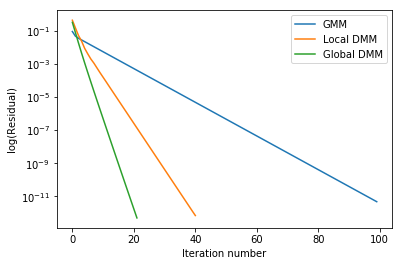

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()